# Aircraft Model: LSTM and GNN for Simplified Edge Connections

This notebook demonstrates the use of a Long Short-Term Memory (LSTM) network combined with a Graph Neural Network (GNN) to model and predict the aerodynamic behavior of an eVTOL an aircraft. The LSTM is used to capture temporal dependencies in the data, while the GNN is employed to handle the spatial relationships between different components of the aircraft. The simplified edge connections in the GNN help in reducing computational complexity while maintaining the accuracy of the model.

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from typing import Optional
from torch.utils.data import Dataset

import joblib
from sklearn.preprocessing import MinMaxScaler

from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import networkx as nx
from torch_geometric.utils import to_networkx
from torch.utils.data import random_split

In [ ]:
project_path = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/'
model_save_path = project_path + 'trained_models/'
result_out_path = project_path + 'result/aircraft_model/'


VISUAILIZE_GRAPH = False
TRAIN_MODEL = False
SAVE_TRAINED_MODEL = False

PLOT_RESULT = True
SAVE_PLOT = False
SAVE_RESULT = True


In [2]:
# Select the device to use - preferably GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Add the path to the utility functions
sys.path.append(project_path + '/src/')     # Add "src" to the system path


# Import necessary utility functions
from utility_functions import downsample_to_35
from utility_functions import organize_data

# Import all the models
from af_escnn_cl import ESCNN_Cl
from af_escnn_cd import ESCNN_Cd

from af_rbf_cl import RBFLayer_cl, RBFNet_cl
from af_rbf_cd import RBFLayer_cd, RBFNet_cd

/mnt/e/eVTOL_model/eVTOL-VehicleModel/


### Initialize Airfoil Models

In [13]:
# Initialize airfoil models
root_airfoilModelsTrained = project_path + '/trained_models/models/airfoil/'

# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()

input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()



/tmp/ipykernel_15533/4063869800.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_mode

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

## Load Wing Data

In [14]:
from create_wing_dataset import WingDataset, subdir_condition_wing   # Make sure to reload the create wing dataset module manually after changes


root_dir_wing = project_path + '/FLOWUnsteady_simulations/aircraft_data/training_data'

# Canard dataset
dataset_canard = WingDataset(root_dir_wing, 
                                af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                airfoil_cl=airfoil_cl, 
                                airfoil_cd=airfoil_cd, 
                                device=device,
                                wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                subdir_condition=subdir_condition_wing)

inputs_canard, outputs_canard = dataset_canard[0:]

input_tensor_canard = inputs_canard
input_tensor_canard = inputs_canard.squeeze(1)  # Reshaping
print("Input shape (Canard dataset):", input_tensor_canard.shape)

output_tensor_canard = outputs_canard.squeeze(1)
print("Output shape (Canard dataset):",output_tensor_canard.shape) 

# Wing dataset
dataset_wing = WingDataset(root_dir_wing, 
                            af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                            af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                            airfoil_cl=airfoil_cl, 
                            airfoil_cd=airfoil_cd, 
                            device=device,
                            wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                            subdir_condition=subdir_condition_wing)

inputs_wing, outputs_wing = dataset_wing[0:]

input_tensor_wing = inputs_wing
input_tensor_wing = inputs_wing.squeeze(1)  # Reshaping
print("Input shape (Wing dataset):", input_tensor_wing.shape)

output_tensor_wing = outputs_wing.squeeze(1)
print("Output shape (Wing dataset):",output_tensor_wing.shape) 




create_wing_dataset module loaded


/mnt/e/eVTOL_model/eVTOL-VehicleModel//src/create_wing_dataset.py:376: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


Input shape (Canard dataset): torch.Size([42, 277, 10])
Output shape (Canard dataset): torch.Size([42, 277, 2])
Input shape (Wing dataset): torch.Size([42, 277, 10])
Output shape (Wing dataset): torch.Size([42, 277, 2])


## Load Rotor Data

In [15]:
from create_rotor_dataset import PropellerDataset, subdir_condition_rotor

# Root directory where simulation subdirectories are stored

root_dir_rotor = project_path + '/FLOWUnsteady_simulations/aircraft_data/training_data'

# dataset - Rotor L1
dataset_rotor_L1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL1, outputs_rL1 = dataset_rotor_L1[0:]


input_tensor_rL1 = inputs_rL1.squeeze(1)  # Reshaping
print("Input shape (rotor - L1):", input_tensor_rL1.shape) 

output_tensor_rL1 = outputs_rL1.squeeze(1)
print("Output shape (rotor - L1):",output_tensor_rL1.shape) 


# dataset - Rotor L2
dataset_rotor_L2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL2, outputs_rL2 = dataset_rotor_L2[0:]


input_tensor_rL2 = inputs_rL2.squeeze(1)  # Reshaping
print("Input shape (rotor - L2):", input_tensor_rL2.shape) 

output_tensor_rL2 = outputs_rL2.squeeze(1)
print("Output shape (rotor - L2):",output_tensor_rL2.shape) 

# dataset - Rotor L3
dataset_rotor_L3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL3, outputs_rL3 = dataset_rotor_L3[0:]


input_tensor_rL3 = inputs_rL3.squeeze(1)  # Reshaping
print("Input shape (rotor - L3):", input_tensor_rL3.shape) 

output_tensor_rL3 = outputs_rL3.squeeze(1)
print("Output shape (rotor - L3):",output_tensor_rL3.shape) 

# dataset - Rotor L4
dataset_rotor_L4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL4, outputs_rL4 = dataset_rotor_L4[0:]


input_tensor_rL4 = inputs_rL4.squeeze(1)  # Reshaping
print("Input shape (rotor - L4):", input_tensor_rL4.shape) 

output_tensor_rL4 = outputs_rL4.squeeze(1)
print("Output shape (rotor - L4):",output_tensor_rL4.shape) 

Input shape (rotor - L1): torch.Size([42, 280, 10])
Output shape (rotor - L1): torch.Size([42, 280, 2])
Input shape (rotor - L2): torch.Size([42, 280, 10])
Output shape (rotor - L2): torch.Size([42, 280, 2])
Input shape (rotor - L3): torch.Size([42, 280, 10])
Output shape (rotor - L3): torch.Size([42, 280, 2])
Input shape (rotor - L4): torch.Size([42, 280, 10])
Output shape (rotor - L4): torch.Size([42, 280, 2])


In [16]:
# dataset - Rotor R1
dataset_rotor_R1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR1, outputs_rR1 = dataset_rotor_R1[0:]


input_tensor_rR1 = inputs_rR1.squeeze(1)  # Reshaping
print("Input shape (rotor - R1):", input_tensor_rR1.shape) 

output_tensor_rR1 = outputs_rR1.squeeze(1)
print("Output shape (rotor - R1):",output_tensor_rR1.shape) 


# dataset - Rotor R2
dataset_rotor_R2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR2, outputs_rR2 = dataset_rotor_R2[0:]


input_tensor_rR2 = inputs_rR2.squeeze(1)  # Reshaping
print("Input shape (rotor - R2):", input_tensor_rR2.shape) 

output_tensor_rR2 = outputs_rR2.squeeze(1)
print("Output shape (rotor - R2):",output_tensor_rR2.shape) 

# dataset - Rotor R3
dataset_rotor_R3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR3, outputs_rR3 = dataset_rotor_R3[0:]


input_tensor_rR3 = inputs_rR3.squeeze(1)  # Reshaping
print("Input shape (rotor - R3):", input_tensor_rR3.shape) 

output_tensor_rR3 = outputs_rR3.squeeze(1)
print("Output shape (rotor - R3):",output_tensor_rR3.shape) 

# dataset - Rotor R4
dataset_rotor_R4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR4, outputs_rR4 = dataset_rotor_R4[0:]


input_tensor_rR4 = inputs_rR4.squeeze(1)  # Reshaping
print("Input shape (rotor - R4):", input_tensor_rR4.shape) 

output_tensor_rR4 = outputs_rR4.squeeze(1)
print("Output shape (rotor - R4):",output_tensor_rR4.shape) 

Input shape (rotor - R1): torch.Size([42, 280, 10])
Output shape (rotor - R1): torch.Size([42, 280, 2])
Input shape (rotor - R2): torch.Size([42, 280, 10])
Output shape (rotor - R2): torch.Size([42, 280, 2])
Input shape (rotor - R3): torch.Size([42, 280, 10])
Output shape (rotor - R3): torch.Size([42, 280, 2])
Input shape (rotor - R4): torch.Size([42, 280, 10])
Output shape (rotor - R4): torch.Size([42, 280, 2])


## Load Wing Model and Initialize

In [17]:
from wing_static import LSTMNet_static

# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 3            # Number of LSTM layers

class WingModel_static(LSTMNet_static):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model

root_wingModelsTrained = project_path + '/trained_models/models/wing/'
root_wingScalersTrained = project_path + '/trained_models/scalers/wing/'

wing_model_static = WingModel_static()
wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
wing_model_static.eval()

# Load the scaler
input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

input_scaler_wing_temp = MinMaxScaler()
output_scaler_wing_temp = MinMaxScaler()

input_scaler_canard_temp = MinMaxScaler()
output_scaler_canard_temp = MinMaxScaler()

/tmp/ipykernel_15533/3446642864.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO

## Load Rotor Model and Initialize

In [18]:
from rotor_model import LSTMNet_rotor

input_size = 10
hidden_size = 100
output_size = 2
num_layers = 4

class PropModel(LSTMNet_rotor):
    def __init__(self):
        super(PropModel, self).__init__(input_size, hidden_size, output_size, num_layers)

root_rotorModelsTrained = project_path + '/trained_models/models/rotor/'
root_rotorScalersTrained = project_path + '/trained_models/scalers/rotor/'

# Initialize the model
# prop_model = PropModel()
# # /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth
# # prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2024-10-04_propModel_lr0.005_e1500_nL2_numNN50.pth'))
# prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth'))
# prop_model = prop_model.to(device)
# prop_model.eval()

# Load the scaler
# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_ipScaler_lr0.005_e1500_nL2_numNN50.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_opScaler_lr0.005_e1500_nL2_numNN50.pkl')

# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_ipScaler_lr0.001_e2500_nL4_numNN100.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_opScaler_lr0.001_e2500_nL4_numNN100.pkl')

rotor1_model = PropModel()
rotor2_model = PropModel()
rotor3_model = PropModel()
rotor4_model = PropModel()

rotor1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor1_lr0.0002_e2500_nL4_numNN100.pth'))
rotor2_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor2_lr0.0002_e2500_nL4_numNN100.pth'))
rotor3_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor3_lr0.0002_e2500_nL4_numNN100.pth'))
rotor4_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor4_lr0.0002_e2500_nL4_numNN100.pth'))


rotor1_model = rotor1_model.to(device)
rotor2_model = rotor2_model.to(device)
rotor3_model = rotor3_model.to(device)
rotor4_model = rotor4_model.to(device)

# 2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl
input_scaler_rotor1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

/tmp/ipykernel_15533/4040284321.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotor1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropMode

In [ ]:
# Function to align the rotor data to the same length
def align_timesteps(data, target_length):
    original_length = data.shape[1]
    x = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x, data, axis=1, kind='linear')
    return interpolator(x_new)


## Aircraft dataset class

In [ ]:
class AircraftDataset(Dataset):
    def __init__(self, wing_dataset,
                       canard_dataset, 
                       propeller_L1_dataset, 
                       propeller_L2_dataset,
                       propeller_L3_dataset, 
                       propeller_L4_dataset, 
                       propeller_R1_dataset, 
                       propeller_R2_dataset,
                       propeller_R3_dataset, 
                       propeller_R4_dataset,
                       wing_ip_scaler, wing_op_scaler,
                       canard_ip_scaler, canard_op_scaler,
                       rotor1_ip_scaler, rotor1_op_scaler,
                       rotor2_ip_scaler, rotor2_op_scaler,
                       rotor3_ip_scaler, rotor3_op_scaler,
                       rotor4_ip_scaler, rotor4_op_scaler,
                       additional_data=None):
        super().__init__()
        self.wing_dataset = wing_dataset
        self.canard_dataset = canard_dataset
        self.propeller_dataset_L1 = propeller_L1_dataset
        self.propeller_dataset_L2 = propeller_L2_dataset
        self.propeller_dataset_L3 = propeller_L3_dataset
        self.propeller_dataset_L4 = propeller_L4_dataset
        self.propeller_dataset_R1 = propeller_R1_dataset
        self.propeller_dataset_R2 = propeller_R2_dataset
        self.propeller_dataset_R3 = propeller_R3_dataset
        self.propeller_dataset_R4 = propeller_R4_dataset
        
        self.additional_data = additional_data or {}
        self.wing_ip_scaler = wing_ip_scaler
        self.wing_op_scaler = wing_op_scaler
        self.canard_ip_scaler = canard_ip_scaler
        self.canard_op_scaler = canard_op_scaler
        self.rotor1_ip_scaler = rotor1_ip_scaler
        self.rotor1_op_scaler = rotor1_op_scaler
        self.rotor2_ip_scaler = rotor2_ip_scaler
        self.rotor2_op_scaler = rotor2_op_scaler
        self.rotor3_ip_scaler = rotor3_ip_scaler
        self.rotor3_op_scaler = rotor3_op_scaler
        self.rotor4_ip_scaler = rotor4_ip_scaler
        self.rotor4_op_scaler = rotor4_op_scaler

        # Constants
        k = 0.1301
        self.constants = {
            # Coordinates of the wing, canars and rotors

            "rotor_L1": torch.tensor([0.36 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L2": torch.tensor([2.28 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L3": torch.tensor([4.2 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L4": torch.tensor([6.54 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R1": torch.tensor([0.36 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R2": torch.tensor([2.28 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R3": torch.tensor([4.2 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R4": torch.tensor([6.54 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "canard": torch.tensor([1.14 * k, 0.0, 0.35 * k], dtype=torch.float32),
            "wing": torch.tensor([4.505 * k, 0.0, -0.2 * k], dtype=torch.float32),
            

        }

        # Initialize data storage
        self.data = {
            "time_varying_inputs": None,
            "constant_inputs": None,
            "node_data": {},  # Store node-specific time-varying data
        }
        self.targets = None

        # Combine datasets
        self._combine_data()

    def _combine_data(self):
        # Load wing and rotor datasets

        # Wing dataset
        inputs_wing, target_wing = self.wing_dataset[0:]
        inputs_wing = inputs_wing.squeeze(1)
        target_wing = target_wing.squeeze(1)
        # Canard dataset
        inputs_canard, target_canard = self.canard_dataset[0:]
        inputs_canard = inputs_canard.squeeze(1)
        target_canard = target_canard.squeeze(1)
        # Rotor - L1 dataset
        inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
        inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
        target_rotor_L1 = target_rotor_L1.squeeze(1)
        # Rotor - L2 dataset
        inputs_rotor_L2, target_rotor_L2 = self.propeller_dataset_L2[0:]
        inputs_rotor_L2 = inputs_rotor_L2.squeeze(1)
        target_rotor_L2 = target_rotor_L2.squeeze(1)
        # Rotor - L3 dataset
        inputs_rotor_L3, target_rotor_L3 = self.propeller_dataset_L3[0:]    
        inputs_rotor_L3 = inputs_rotor_L3.squeeze(1)
        target_rotor_L3 = target_rotor_L3.squeeze(1)
        # Rotor - L4 dataset
        inputs_rotor_L4, target_rotor_L4 = self.propeller_dataset_L4[0:]
        inputs_rotor_L4 = inputs_rotor_L4.squeeze(1)
        target_rotor_L4 = target_rotor_L4.squeeze(1)

        # Rotor - R1 dataset
        inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
        inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
        target_rotor_R1 = target_rotor_R1.squeeze(1)

        # Rotor - R2 dataset
        inputs_rotor_R2, target_rotor_R2 = self.propeller_dataset_R2[0:]
        inputs_rotor_R2 = inputs_rotor_R2.squeeze(1)
        target_rotor_R2 = target_rotor_R2.squeeze(1)

        # Rotor - R3 dataset
        inputs_rotor_R3, target_rotor_R3 = self.propeller_dataset_R3[0:]
        inputs_rotor_R3 = inputs_rotor_R3.squeeze(1)
        target_rotor_R3 = target_rotor_R3.squeeze(1)

        # Rotor - R4 dataset
        inputs_rotor_R4, target_rotor_R4 = self.propeller_dataset_R4[0:]
        inputs_rotor_R4 = inputs_rotor_R4.squeeze(1)
        target_rotor_R4 = target_rotor_R4.squeeze(1)

        # Normalize the wing and canard inputs
        inputs_wing_reshaped = inputs_wing.reshape(-1, 10)
        inputs_wing_normalized = self.wing_ip_scaler.fit_transform(inputs_wing_reshaped.reshape(-1, 10)).reshape(inputs_wing.shape)
        inputs_wing_normalized = torch.tensor(inputs_wing_normalized, dtype=torch.float32)

        inputs_canard_reshaped = inputs_canard.reshape(-1, 10)
        inputs_canard_normalized = self.canard_ip_scaler.fit_transform(inputs_canard_reshaped.reshape(-1, 10)).reshape(inputs_canard.shape)
        inputs_canard_normalized = torch.tensor(inputs_canard_normalized, dtype=torch.float32)

        # Time-varying features
        T = inputs_wing_normalized[:, :, 0]
        AOA = inputs_wing_normalized[:, :, 1]
        v_inf = inputs_wing_normalized[:, :, 2]


        # Resize the rotor inputs
        inputs_resized_rotor_L1 = torch.tensor(align_timesteps(inputs_rotor_L1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L2 = torch.tensor(align_timesteps(inputs_rotor_L2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L3 = torch.tensor(align_timesteps(inputs_rotor_L3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L4 = torch.tensor(align_timesteps(inputs_rotor_L4, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R1 = torch.tensor(align_timesteps(inputs_rotor_R1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R2 = torch.tensor(align_timesteps(inputs_rotor_R2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R3 = torch.tensor(align_timesteps(inputs_rotor_R3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R4 = torch.tensor(align_timesteps(inputs_rotor_R4, T.shape[1]), dtype=torch.float32)
        
        # Normalize the rotor inputs
        inputs_rotor_L1_reshaped = inputs_resized_rotor_L1.reshape(-1, 10)
        inputs_rotor_L1_normalized = self.rotor1_ip_scaler.transform(inputs_rotor_L1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L1.shape)
        inputs_rotor_L1_normalized = torch.tensor(inputs_rotor_L1_normalized, dtype=torch.float32)

        inputs_rotor_L2_reshaped = inputs_resized_rotor_L2.reshape(-1, 10)
        inputs_rotor_L2_normalized = self.rotor2_ip_scaler.transform(inputs_rotor_L2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L2.shape)
        inputs_rotor_L2_normalized = torch.tensor(inputs_rotor_L2_normalized, dtype=torch.float32)

        inputs_rotor_L3_reshaped = inputs_resized_rotor_L3.reshape(-1, 10)
        inputs_rotor_L3_normalized = self.rotor3_ip_scaler.transform(inputs_rotor_L3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L3.shape)
        inputs_rotor_L3_normalized = torch.tensor(inputs_rotor_L3_normalized, dtype=torch.float32)

        inputs_rotor_L4_reshaped = inputs_resized_rotor_L4.reshape(-1, 10)
        inputs_rotor_L4_normalized = self.rotor4_ip_scaler.transform(inputs_rotor_L4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L4.shape)
        inputs_rotor_L4_normalized = torch.tensor(inputs_rotor_L4_normalized, dtype=torch.float32)

        inputs_rotor_R1_reshaped = inputs_resized_rotor_R1.reshape(-1, 10)
        inputs_rotor_R1_normalized = self.rotor1_ip_scaler.transform(inputs_rotor_R1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R1.shape)
        inputs_rotor_R1_normalized = torch.tensor(inputs_rotor_R1_normalized, dtype=torch.float32)

        inputs_rotor_R2_reshaped = inputs_resized_rotor_R2.reshape(-1, 10)
        inputs_rotor_R2_normalized = self.rotor2_ip_scaler.transform(inputs_rotor_R2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R2.shape)
        inputs_rotor_R2_normalized = torch.tensor(inputs_rotor_R2_normalized, dtype=torch.float32)

        inputs_rotor_R3_reshaped = inputs_resized_rotor_R3.reshape(-1, 10)
        inputs_rotor_R3_normalized = self.rotor3_ip_scaler.transform(inputs_rotor_R3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R3.shape)
        inputs_rotor_R3_normalized = torch.tensor(inputs_rotor_R3_normalized, dtype=torch.float32)

        inputs_rotor_R4_reshaped = inputs_resized_rotor_R4.reshape(-1, 10)
        inputs_rotor_R4_normalized = self.rotor4_ip_scaler.transform(inputs_rotor_R4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R4.shape)
        inputs_rotor_R4_normalized = torch.tensor(inputs_rotor_R4_normalized, dtype=torch.float32)

        
        omega = inputs_rotor_L1_normalized[:, :, 1]
        sine_component = inputs_rotor_L1_normalized[:, :, 4]
        cos_component = inputs_rotor_L1_normalized[:, :, 5]


        # Store time-varying inputs in self.data
        self.data["time_varying_inputs"] = torch.stack([T, AOA, v_inf, omega], dim=2)       # [num_simulations, n_timesteps, 6]
        self.data["node_data"]["rotor_L1"] = inputs_rotor_L1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L2"] = inputs_rotor_L2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L3"] = inputs_rotor_L3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L4"] = inputs_rotor_L4_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R1"] = inputs_rotor_R1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R2"] = inputs_rotor_R2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R3"] = inputs_rotor_R3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R4"] = inputs_rotor_R4_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["canard"] = inputs_canard_normalized                # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["wing"] = inputs_wing_normalized                    # [num_simulations, n_timesteps, 10]
        
        # Store constant features
        self.data["constant_inputs"] = torch.stack(list(self.constants.values()))

        # Combine targets
        target_rotor_L1 = torch.tensor(align_timesteps(target_rotor_L1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R1 = torch.tensor(align_timesteps(target_rotor_R1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L2 = torch.tensor(align_timesteps(target_rotor_L2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R2 = torch.tensor(align_timesteps(target_rotor_R2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L3 = torch.tensor(align_timesteps(target_rotor_L3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R3 = torch.tensor(align_timesteps(target_rotor_R3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L4 = torch.tensor(align_timesteps(target_rotor_L4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R4 = torch.tensor(align_timesteps(target_rotor_R4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]

        target_wing_reshaped = target_wing.reshape(-1, 2)
        target_wing_normalized = self.wing_op_scaler.fit_transform(target_wing_reshaped.reshape(-1, 2)).reshape(target_wing.shape)
        target_wing_normalized = torch.tensor(target_wing_normalized, dtype=torch.float32)

        target_canard_reshaped = target_canard.reshape(-1, 2)
        target_canard_normalized = self.canard_op_scaler.fit_transform(target_canard_reshaped.reshape(-1, 2)).reshape(target_canard.shape)
        target_canard_normalized = torch.tensor(target_canard_normalized, dtype=torch.float32)

        target_rotor_L1_reshaped = target_rotor_L1.reshape(-1, 2)
        target_rotor_L1_normalized = self.rotor1_op_scaler.transform(target_rotor_L1_reshaped.reshape(-1, 2)).reshape(target_rotor_L1.shape)
        target_rotor_L1_normalized = torch.tensor(target_rotor_L1_normalized, dtype=torch.float32)

        target_rotor_L2_reshaped = target_rotor_L2.reshape(-1, 2)
        target_rotor_L2_normalized = self.rotor2_op_scaler.transform(target_rotor_L2_reshaped.reshape(-1, 2)).reshape(target_rotor_L2.shape)
        target_rotor_L2_normalized = torch.tensor(target_rotor_L2_normalized, dtype=torch.float32)

        target_rotor_L3_reshaped = target_rotor_L3.reshape(-1, 2)
        target_rotor_L3_normalized = self.rotor3_op_scaler.transform(target_rotor_L3_reshaped.reshape(-1, 2)).reshape(target_rotor_L3.shape)
        target_rotor_L3_normalized = torch.tensor(target_rotor_L3_normalized, dtype=torch.float32)

        target_rotor_L4_reshaped = target_rotor_L4.reshape(-1, 2)
        target_rotor_L4_normalized = self.rotor4_op_scaler.transform(target_rotor_L4_reshaped.reshape(-1, 2)).reshape(target_rotor_L4.shape)
        target_rotor_L4_normalized = torch.tensor(target_rotor_L4_normalized, dtype=torch.float32)

        target_rotor_R1_reshaped = target_rotor_R1.reshape(-1, 2)
        target_rotor_R1_normalized = self.rotor1_op_scaler.transform(target_rotor_R1_reshaped.reshape(-1, 2)).reshape(target_rotor_R1.shape)
        target_rotor_R1_normalized = torch.tensor(target_rotor_R1_normalized, dtype=torch.float32)

        target_rotor_R2_reshaped = target_rotor_R2.reshape(-1, 2)
        target_rotor_R2_normalized = self.rotor2_op_scaler.transform(target_rotor_R2_reshaped.reshape(-1, 2)).reshape(target_rotor_R2.shape)
        target_rotor_R2_normalized = torch.tensor(target_rotor_R2_normalized, dtype=torch.float32)

        target_rotor_R3_reshaped = target_rotor_R3.reshape(-1, 2)
        target_rotor_R3_normalized = self.rotor3_op_scaler.transform(target_rotor_R3_reshaped.reshape(-1, 2)).reshape(target_rotor_R3.shape)
        target_rotor_R3_normalized = torch.tensor(target_rotor_R3_normalized, dtype=torch.float32)

        target_rotor_R4_reshaped = target_rotor_R4.reshape(-1, 2)
        target_rotor_R4_normalized = self.rotor4_op_scaler.transform(target_rotor_R4_reshaped.reshape(-1, 2)).reshape(target_rotor_R4.shape)
        target_rotor_R4_normalized = torch.tensor(target_rotor_R4_normalized, dtype=torch.float32)

        self.targets = torch.cat([target_rotor_L1_normalized, target_rotor_L2_normalized,
                                   target_rotor_L3_normalized, target_rotor_L4_normalized,
                                   target_rotor_R1_normalized, target_rotor_R2_normalized,
                                   target_rotor_R3_normalized, target_rotor_R4_normalized,
                                   target_canard_normalized, target_wing_normalized], dim=2)

                                   

    def __len__(self):
        return len(self.data["time_varying_inputs"])

    def __getitem__(self, idx):
        inputs = {
            "node_data": {
                "rotor_L1": self.data["node_data"]["rotor_L1"][idx],
                "rotor_L2": self.data["node_data"]["rotor_L2"][idx],
                "rotor_L3": self.data["node_data"]["rotor_L3"][idx],
                "rotor_L4": self.data["node_data"]["rotor_L4"][idx],
                "rotor_R1": self.data["node_data"]["rotor_R1"][idx],
                "rotor_R2": self.data["node_data"]["rotor_R2"][idx],
                "rotor_R3": self.data["node_data"]["rotor_R3"][idx],
                "rotor_R4": self.data["node_data"]["rotor_R4"][idx],
                "canard": self.data["node_data"]["canard"][idx],
                "wing": self.data["node_data"]["wing"][idx]
            },
            "constant_inputs": self.data["constant_inputs"],
            "time_varying_inputs": self.data["time_varying_inputs"][idx]
        }
        targets = self.targets[idx]
        return inputs, targets


In [20]:
class AircraftDataset(Dataset):
    def __init__(self, wing_dataset,
                       canard_dataset, 
                       propeller_L1_dataset, 
                       propeller_L2_dataset,
                       propeller_L3_dataset, 
                       propeller_L4_dataset, 
                       propeller_R1_dataset, 
                       propeller_R2_dataset,
                       propeller_R3_dataset, 
                       propeller_R4_dataset,
                       wing_ip_scaler, wing_op_scaler,
                       canard_ip_scaler, canard_op_scaler,
                       rotor1_ip_scaler, rotor1_op_scaler,
                       rotor2_ip_scaler, rotor2_op_scaler,
                       rotor3_ip_scaler, rotor3_op_scaler,
                       rotor4_ip_scaler, rotor4_op_scaler,
                       additional_data=None):
        """
        Initializes the AircraftDataset.

        Args:
            wing_dataset (Dataset): Dataset for the wing.
            canard_dataset (Dataset): Dataset for the canard.
            propeller_L1_dataset (Dataset): Dataset for the left propeller 1.
            propeller_L2_dataset (Dataset): Dataset for the left propeller 2.
            propeller_L3_dataset (Dataset): Dataset for the left propeller 3.
            propeller_L4_dataset (Dataset): Dataset for the left propeller 4.
            propeller_R1_dataset (Dataset): Dataset for the right propeller 1.
            propeller_R2_dataset (Dataset): Dataset for the right propeller 2.
            propeller_R3_dataset (Dataset): Dataset for the right propeller 3.
            propeller_R4_dataset (Dataset): Dataset for the right propeller 4.
            wing_ip_scaler (scaler): Scaler for wing input data.
            wing_op_scaler (scaler): Scaler for wing output data.
            canard_ip_scaler (scaler): Scaler for canard input data.
            canard_op_scaler (scaler): Scaler for canard output data.
            rotor1_ip_scaler (scaler): Scaler for rotor 1 input data.
            rotor1_op_scaler (scaler): Scaler for rotor 1 output data.
            rotor2_ip_scaler (scaler): Scaler for rotor 2 input data.
            rotor2_op_scaler (scaler): Scaler for rotor 2 output data.
            rotor3_ip_scaler (scaler): Scaler for rotor 3 input data.
            rotor3_op_scaler (scaler): Scaler for rotor 3 output data.
            rotor4_ip_scaler (scaler): Scaler for rotor 4 input data.
            rotor4_op_scaler (scaler): Scaler for rotor 4 output data.
            additional_data (dict, optional): Additional data to be included. Defaults to None.
        """
        super().__init__()
        self.wing_dataset = wing_dataset
        self.canard_dataset = canard_dataset
        self.propeller_dataset_L1 = propeller_L1_dataset
        self.propeller_dataset_L2 = propeller_L2_dataset
        self.propeller_dataset_L3 = propeller_L3_dataset
        self.propeller_dataset_L4 = propeller_L4_dataset
        self.propeller_dataset_R1 = propeller_R1_dataset
        self.propeller_dataset_R2 = propeller_R2_dataset
        self.propeller_dataset_R3 = propeller_R3_dataset
        self.propeller_dataset_R4 = propeller_R4_dataset
        
        self.additional_data = additional_data or {}
        self.wing_ip_scaler = wing_ip_scaler
        self.wing_op_scaler = wing_op_scaler
        self.canard_ip_scaler = canard_ip_scaler
        self.canard_op_scaler = canard_op_scaler
        self.rotor1_ip_scaler = rotor1_ip_scaler
        self.rotor1_op_scaler = rotor1_op_scaler
        self.rotor2_ip_scaler = rotor2_ip_scaler
        self.rotor2_op_scaler = rotor2_op_scaler
        self.rotor3_ip_scaler = rotor3_ip_scaler
        self.rotor3_op_scaler = rotor3_op_scaler
        self.rotor4_ip_scaler = rotor4_ip_scaler
        self.rotor4_op_scaler = rotor4_op_scaler

        # Constants - Aircraft components represented as cartisian coordinates
        k = 0.1301
        self.constants = {
            # Coordinates of the wing, canars and rotors

            "rotor_L1": torch.tensor([0.36 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L2": torch.tensor([2.28 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L3": torch.tensor([4.2 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L4": torch.tensor([6.54 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R1": torch.tensor([0.36 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R2": torch.tensor([2.28 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R3": torch.tensor([4.2 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_R4": torch.tensor([6.54 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            "canard": torch.tensor([1.14 * k, 0.0, 0.35 * k], dtype=torch.float32),
            "wing": torch.tensor([4.505 * k, 0.0, -0.2 * k], dtype=torch.float32),
            

        }

        # Initialize data storage
        self.data = {
            "time_varying_inputs": None,
            "constant_inputs": None,
            "node_data": {},  # Store node-specific time-varying data
        }
        self.targets = None

        # Combine datasets
        self._combine_data()

    def _combine_data(self):
        # Load wing and rotor datasets

        # Wing dataset
        inputs_wing, target_wing = self.wing_dataset[0:]
        inputs_wing = inputs_wing.squeeze(1)
        target_wing = target_wing.squeeze(1)
        # Canard dataset
        inputs_canard, target_canard = self.canard_dataset[0:]
        inputs_canard = inputs_canard.squeeze(1)
        target_canard = target_canard.squeeze(1)
        # Rotor - L1 dataset
        inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
        inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
        target_rotor_L1 = target_rotor_L1.squeeze(1)
        # Rotor - L2 dataset
        inputs_rotor_L2, target_rotor_L2 = self.propeller_dataset_L2[0:]
        inputs_rotor_L2 = inputs_rotor_L2.squeeze(1)
        target_rotor_L2 = target_rotor_L2.squeeze(1)
        # Rotor - L3 dataset
        inputs_rotor_L3, target_rotor_L3 = self.propeller_dataset_L3[0:]    
        inputs_rotor_L3 = inputs_rotor_L3.squeeze(1)
        target_rotor_L3 = target_rotor_L3.squeeze(1)
        # Rotor - L4 dataset
        inputs_rotor_L4, target_rotor_L4 = self.propeller_dataset_L4[0:]
        inputs_rotor_L4 = inputs_rotor_L4.squeeze(1)
        target_rotor_L4 = target_rotor_L4.squeeze(1)

        # Rotor - R1 dataset
        inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
        inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
        target_rotor_R1 = target_rotor_R1.squeeze(1)

        # Rotor - R2 dataset
        inputs_rotor_R2, target_rotor_R2 = self.propeller_dataset_R2[0:]
        inputs_rotor_R2 = inputs_rotor_R2.squeeze(1)
        target_rotor_R2 = target_rotor_R2.squeeze(1)

        # Rotor - R3 dataset
        inputs_rotor_R3, target_rotor_R3 = self.propeller_dataset_R3[0:]
        inputs_rotor_R3 = inputs_rotor_R3.squeeze(1)
        target_rotor_R3 = target_rotor_R3.squeeze(1)

        # Rotor - R4 dataset
        inputs_rotor_R4, target_rotor_R4 = self.propeller_dataset_R4[0:]
        inputs_rotor_R4 = inputs_rotor_R4.squeeze(1)
        target_rotor_R4 = target_rotor_R4.squeeze(1)

        # Normalize the wing and canard inputs
        inputs_wing_reshaped = inputs_wing.reshape(-1, 10)
        inputs_wing_normalized = self.wing_ip_scaler.fit_transform(inputs_wing_reshaped.reshape(-1, 10)).reshape(inputs_wing.shape)
        inputs_wing_normalized = torch.tensor(inputs_wing_normalized, dtype=torch.float32)

        inputs_canard_reshaped = inputs_canard.reshape(-1, 10)
        inputs_canard_normalized = self.canard_ip_scaler.fit_transform(inputs_canard_reshaped.reshape(-1, 10)).reshape(inputs_canard.shape)
        inputs_canard_normalized = torch.tensor(inputs_canard_normalized, dtype=torch.float32)

        # Time-varying features
        T = inputs_wing_normalized[:, :, 0]
        AOA = inputs_wing_normalized[:, :, 1]
        v_inf = inputs_wing_normalized[:, :, 2]


        # Resize the rotor inputs
        inputs_resized_rotor_L1 = torch.tensor(align_timesteps(inputs_rotor_L1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L2 = torch.tensor(align_timesteps(inputs_rotor_L2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L3 = torch.tensor(align_timesteps(inputs_rotor_L3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L4 = torch.tensor(align_timesteps(inputs_rotor_L4, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R1 = torch.tensor(align_timesteps(inputs_rotor_R1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R2 = torch.tensor(align_timesteps(inputs_rotor_R2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R3 = torch.tensor(align_timesteps(inputs_rotor_R3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R4 = torch.tensor(align_timesteps(inputs_rotor_R4, T.shape[1]), dtype=torch.float32)
        
        # Normalize the rotor inputs
        inputs_rotor_L1_reshaped = inputs_resized_rotor_L1.reshape(-1, 10)
        inputs_rotor_L1_normalized = self.rotor1_ip_scaler.transform(inputs_rotor_L1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L1.shape)
        inputs_rotor_L1_normalized = torch.tensor(inputs_rotor_L1_normalized, dtype=torch.float32)

        inputs_rotor_L2_reshaped = inputs_resized_rotor_L2.reshape(-1, 10)
        inputs_rotor_L2_normalized = self.rotor2_ip_scaler.transform(inputs_rotor_L2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L2.shape)
        inputs_rotor_L2_normalized = torch.tensor(inputs_rotor_L2_normalized, dtype=torch.float32)

        inputs_rotor_L3_reshaped = inputs_resized_rotor_L3.reshape(-1, 10)
        inputs_rotor_L3_normalized = self.rotor3_ip_scaler.transform(inputs_rotor_L3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L3.shape)
        inputs_rotor_L3_normalized = torch.tensor(inputs_rotor_L3_normalized, dtype=torch.float32)

        inputs_rotor_L4_reshaped = inputs_resized_rotor_L4.reshape(-1, 10)
        inputs_rotor_L4_normalized = self.rotor4_ip_scaler.transform(inputs_rotor_L4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L4.shape)
        inputs_rotor_L4_normalized = torch.tensor(inputs_rotor_L4_normalized, dtype=torch.float32)

        inputs_rotor_R1_reshaped = inputs_resized_rotor_R1.reshape(-1, 10)
        inputs_rotor_R1_normalized = self.rotor1_ip_scaler.transform(inputs_rotor_R1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R1.shape)
        inputs_rotor_R1_normalized = torch.tensor(inputs_rotor_R1_normalized, dtype=torch.float32)

        inputs_rotor_R2_reshaped = inputs_resized_rotor_R2.reshape(-1, 10)
        inputs_rotor_R2_normalized = self.rotor2_ip_scaler.transform(inputs_rotor_R2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R2.shape)
        inputs_rotor_R2_normalized = torch.tensor(inputs_rotor_R2_normalized, dtype=torch.float32)

        inputs_rotor_R3_reshaped = inputs_resized_rotor_R3.reshape(-1, 10)
        inputs_rotor_R3_normalized = self.rotor3_ip_scaler.transform(inputs_rotor_R3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R3.shape)
        inputs_rotor_R3_normalized = torch.tensor(inputs_rotor_R3_normalized, dtype=torch.float32)

        inputs_rotor_R4_reshaped = inputs_resized_rotor_R4.reshape(-1, 10)
        inputs_rotor_R4_normalized = self.rotor4_ip_scaler.transform(inputs_rotor_R4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R4.shape)
        inputs_rotor_R4_normalized = torch.tensor(inputs_rotor_R4_normalized, dtype=torch.float32)

        
        omega = inputs_rotor_L1_normalized[:, :, 1]
        sine_component = inputs_rotor_L1_normalized[:, :, 4]
        cos_component = inputs_rotor_L1_normalized[:, :, 5]


        # Store time-varying inputs in self.data
        self.data["time_varying_inputs"] = torch.stack([T, AOA, v_inf, omega], dim=2)       # [num_simulations, n_timesteps, 6]
        self.data["node_data"]["rotor_L1"] = inputs_rotor_L1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L2"] = inputs_rotor_L2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L3"] = inputs_rotor_L3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L4"] = inputs_rotor_L4_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R1"] = inputs_rotor_R1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R2"] = inputs_rotor_R2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R3"] = inputs_rotor_R3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_R4"] = inputs_rotor_R4_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["canard"] = inputs_canard_normalized                # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["wing"] = inputs_wing_normalized                    # [num_simulations, n_timesteps, 10]
        
        # Store constant features
        self.data["constant_inputs"] = torch.stack(list(self.constants.values()))

        # Combine targets
        target_rotor_L1 = torch.tensor(align_timesteps(target_rotor_L1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R1 = torch.tensor(align_timesteps(target_rotor_R1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L2 = torch.tensor(align_timesteps(target_rotor_L2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R2 = torch.tensor(align_timesteps(target_rotor_R2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L3 = torch.tensor(align_timesteps(target_rotor_L3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R3 = torch.tensor(align_timesteps(target_rotor_R3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L4 = torch.tensor(align_timesteps(target_rotor_L4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R4 = torch.tensor(align_timesteps(target_rotor_R4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]

        # Normalize the wing and canard outputs
        target_wing_reshaped = target_wing.reshape(-1, 2)
        target_wing_normalized = self.wing_op_scaler.fit_transform(target_wing_reshaped.reshape(-1, 2)).reshape(target_wing.shape)
        target_wing_normalized = torch.tensor(target_wing_normalized, dtype=torch.float32)

        target_canard_reshaped = target_canard.reshape(-1, 2)
        target_canard_normalized = self.canard_op_scaler.fit_transform(target_canard_reshaped.reshape(-1, 2)).reshape(target_canard.shape)
        target_canard_normalized = torch.tensor(target_canard_normalized, dtype=torch.float32)

        # Normalize the rotor outputs
        target_rotor_L1_reshaped = target_rotor_L1.reshape(-1, 2)
        target_rotor_L1_normalized = self.rotor1_op_scaler.transform(target_rotor_L1_reshaped.reshape(-1, 2)).reshape(target_rotor_L1.shape)
        target_rotor_L1_normalized = torch.tensor(target_rotor_L1_normalized, dtype=torch.float32)

        target_rotor_L2_reshaped = target_rotor_L2.reshape(-1, 2)
        target_rotor_L2_normalized = self.rotor2_op_scaler.transform(target_rotor_L2_reshaped.reshape(-1, 2)).reshape(target_rotor_L2.shape)
        target_rotor_L2_normalized = torch.tensor(target_rotor_L2_normalized, dtype=torch.float32)

        target_rotor_L3_reshaped = target_rotor_L3.reshape(-1, 2)
        target_rotor_L3_normalized = self.rotor3_op_scaler.transform(target_rotor_L3_reshaped.reshape(-1, 2)).reshape(target_rotor_L3.shape)
        target_rotor_L3_normalized = torch.tensor(target_rotor_L3_normalized, dtype=torch.float32)

        target_rotor_L4_reshaped = target_rotor_L4.reshape(-1, 2)
        target_rotor_L4_normalized = self.rotor4_op_scaler.transform(target_rotor_L4_reshaped.reshape(-1, 2)).reshape(target_rotor_L4.shape)
        target_rotor_L4_normalized = torch.tensor(target_rotor_L4_normalized, dtype=torch.float32)

        target_rotor_R1_reshaped = target_rotor_R1.reshape(-1, 2)
        target_rotor_R1_normalized = self.rotor1_op_scaler.transform(target_rotor_R1_reshaped.reshape(-1, 2)).reshape(target_rotor_R1.shape)
        target_rotor_R1_normalized = torch.tensor(target_rotor_R1_normalized, dtype=torch.float32)

        target_rotor_R2_reshaped = target_rotor_R2.reshape(-1, 2)
        target_rotor_R2_normalized = self.rotor2_op_scaler.transform(target_rotor_R2_reshaped.reshape(-1, 2)).reshape(target_rotor_R2.shape)
        target_rotor_R2_normalized = torch.tensor(target_rotor_R2_normalized, dtype=torch.float32)

        target_rotor_R3_reshaped = target_rotor_R3.reshape(-1, 2)
        target_rotor_R3_normalized = self.rotor3_op_scaler.transform(target_rotor_R3_reshaped.reshape(-1, 2)).reshape(target_rotor_R3.shape)
        target_rotor_R3_normalized = torch.tensor(target_rotor_R3_normalized, dtype=torch.float32)

        target_rotor_R4_reshaped = target_rotor_R4.reshape(-1, 2)
        target_rotor_R4_normalized = self.rotor4_op_scaler.transform(target_rotor_R4_reshaped.reshape(-1, 2)).reshape(target_rotor_R4.shape)
        target_rotor_R4_normalized = torch.tensor(target_rotor_R4_normalized, dtype=torch.float32)

        # Combine the targets into a single tensor 
        self.targets = torch.cat([target_rotor_L1_normalized, target_rotor_L2_normalized,
                                   target_rotor_L3_normalized, target_rotor_L4_normalized,
                                   target_rotor_R1_normalized, target_rotor_R2_normalized,
                                   target_rotor_R3_normalized, target_rotor_R4_normalized,
                                   target_canard_normalized, target_wing_normalized], dim=2)

                                   

    def __len__(self):
        return len(self.data["time_varying_inputs"])

    def __getitem__(self, idx):
        inputs = {
            "node_data": {
                "rotor_L1": self.data["node_data"]["rotor_L1"][idx],
                "rotor_L2": self.data["node_data"]["rotor_L2"][idx],
                "rotor_L3": self.data["node_data"]["rotor_L3"][idx],
                "rotor_L4": self.data["node_data"]["rotor_L4"][idx],
                "rotor_R1": self.data["node_data"]["rotor_R1"][idx],
                "rotor_R2": self.data["node_data"]["rotor_R2"][idx],
                "rotor_R3": self.data["node_data"]["rotor_R3"][idx],
                "rotor_R4": self.data["node_data"]["rotor_R4"][idx],
                "canard": self.data["node_data"]["canard"][idx],
                "wing": self.data["node_data"]["wing"][idx]
            },
            "constant_inputs": self.data["constant_inputs"],
            "time_varying_inputs": self.data["time_varying_inputs"][idx]
        }
        targets = self.targets[idx]
        return inputs, targets


## Graph structure

In [ ]:

def create_graph(inputs, targets):
    """
    Create a graph structure from dataset inputs and targets.

    Args:
        inputs (dict): Includes node data and constant inputs.
        targets (Tensor): The target outputs.

    Returns:
        Data: PyTorch Geometric Data object representing the graph.
    """
    # Extract node features
    node_features = torch.stack([
        inputs["node_data"]["rotor_L1"],        # Node 0: Rotor 1 features
        inputs["node_data"]["rotor_L2"],        # Node 1: Rotor 2 features
        inputs["node_data"]["rotor_L3"],        # Node 2: Rotor 3 features
        inputs["node_data"]["rotor_L4"],        # Node 3: Rotor 4 features
        inputs["node_data"]["rotor_R1"],        # Node 4: Rotor 5 features
        inputs["node_data"]["rotor_R2"],        # Node 5: Rotor 6 features
        inputs["node_data"]["rotor_R3"],        # Node 6: Rotor 7 features
        inputs["node_data"]["rotor_R4"],        # Node 7: Rotor 8 features
        inputs["node_data"]["canard"],          # Node 8: Canard features
        inputs["node_data"]["wing"],            # Node 9: Wing features

        
    ], dim=0)  # Shape: (num_nodes, timesteps, features)


    source = [0, 1, 2, 4, 5, 6, 8]
    target = [1, 2, 3, 5, 6, 7, 9]

    # Define edge index (connectivity)
    edge_index = torch.tensor([source, target], dtype=torch.long)

    edge_attr = (inputs["constant_inputs"][torch.tensor(target)] - inputs["constant_inputs"][torch.tensor(source)])

    
    global_inputs = torch.stack([inputs["time_varying_inputs"]])
    global_targets = torch.stack([targets])


    # Create graph data object
    graph = Data(
        x=node_features,                # Node features
        edge_index=edge_index,          # Edge connectivity
        edge_attr=edge_attr,            # Edge features
        global_input = global_inputs,   # Aircraft-level inputs
        y=global_targets                # Targets
    )
    return graph


In [ ]:
# Define a custom dataset class to represent the aircraft dataset as a graph dataset
class GraphDataset(Dataset):
    def __init__(self, dataset):
        """
        Initialize the dataset with a list of inputs and targets.
        
        Args:
            dataset (list): A list of dictionaries, each containing 'inputs' and 'targets'.
        """
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs, targets = self.dataset[idx]
        graph = create_graph(inputs, targets)
        return graph

In [ ]:
# Visualize the graph

def visualize_graph(graph):
    """
    Visualize a PyTorch Geometric graph using NetworkX.
    
    Args:
        graph (torch_geometric.data.Data): The graph to visualize.
    """
    # Convert PyTorch Geometric Data object to NetworkX graph
    nx_graph = to_networkx(graph, edge_attrs=["edge_attr"], to_undirected=True)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph)  # Use spring layout for positioning
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=500,
        edge_color="gray",
        font_weight="bold"
    )

    # Annotate edge attributes
    edge_labels = nx.get_edge_attributes(nx_graph, "edge_attr")
    edge_labels = {k: tuple(round(x, 2) for x in v) for k, v in edge_labels.items()}  # Round for readability
    # edge_labels = {k: round(float(v), 2) for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Graph Structure")
    plt.show()


## Hierarchical Composite GNN Architecture

In [ ]:
class HierarchicalCompositeGNN(nn.Module):
    def __init__(self,
                 pretrained_wing, 
                 pretrained_canard,
                 pretrained_rotor1, pretrained_rotor2,
                 pretrained_rotor3, pretrained_rotor4,
                 global_input_dim,      # (retained for compatibility and scaling)
                 edge_input_dim, 
                 hidden_dim,            # dimension after the transform (and input to LSTM)
                 output_dim,            # final output per node (should be 2)
                 lstm_hidden_dim=None,  # hidden size for the LSTM; if None, set equal to hidden_dim
                 gat_hidden_dim=32,     # hidden dimension for the first GAT layer
                 heads=4,
                 dropout=0.3):
        super(HierarchicalCompositeGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim    # expected to be 2
        self.num_components = 8         # fixed (wing, canard, rotorL1, rotorR1, rotorL2, rotorR2, rotorL3, rotorR3, rotorL4, rotorR4)
        
        # Pre-trained models for each component
        self.pretrained_wing   = pretrained_wing
        self.pretrained_canard = pretrained_canard
        self.pretrained_rotorL1 = pretrained_rotor1
        self.pretrained_rotorL2 = pretrained_rotor2
        self.pretrained_rotorL3 = pretrained_rotor3
        self.pretrained_rotorL4 = pretrained_rotor4
        # For rotor right, re-use the left rotor models (Symmetric)
        self.pretrained_rotorR1 = pretrained_rotor1
        self.pretrained_rotorR2 = pretrained_rotor2
        self.pretrained_rotorR3 = pretrained_rotor3
        self.pretrained_rotorR4 = pretrained_rotor4

        # Transform the outputs of the pre-trained models to hidden_dim.
        # (Assumes the pre-trained outputs have 2 features.)
        self.wing_transform  = nn.Linear(2, hidden_dim)
        self.rotor_transform = nn.Linear(2, hidden_dim)
        
        # Global input transform (if needed)
        self.global_inputs_transform = nn.Linear(global_input_dim, hidden_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout)

        # Lower-level temporal processing: an LSTM operating on each component’s time series.
        if lstm_hidden_dim is None:
            lstm_hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim


        # We have 10 components: rotorL1, rotorR1, rotorL2, rotorR2, rotorL3, rotorR3, rotorL4, rotorR4, canard, wing
        self.num_components = 10
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size=hidden_dim, hidden_size=lstm_hidden_dim, batch_first=True)
            for _ in range(self.num_components)
        ])

        # Higher-level spatial GNN.
        # The GAT layers operate on the graph of components at each timestep.
        self.gat1 = GATConv(lstm_hidden_dim, gat_hidden_dim, heads=heads, concat=True, edge_dim=edge_input_dim)
        self.norm1 = nn.LayerNorm(gat_hidden_dim * heads)
        self.gat2 = GATConv(gat_hidden_dim * heads, lstm_hidden_dim, heads=2, concat=False, edge_dim=edge_input_dim)
        self.norm2 = nn.LayerNorm(lstm_hidden_dim)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, node_inputs, targets, edge_index, edge_attr, global_inputs, batch_size, num_nodes):
        """
        Args:
            node_inputs: Tensor of shape [B * num_components, timesteps, input_feature_dim]
                         (used by the pre-trained models for rotor nodes).
            targets: Tensor of shape [B, timesteps, some_feature_dim]
                     (used for wing and canard components).
            edge_index: Edge connectivity for the higher-level graph (for a graph with num_components nodes).
            edge_attr: Edge attributes for the higher-level graph.
            global_inputs: (Not used in this model (Exists for scalibility))
            batch_size: number of samples in the batch.
            num_nodes: total number of nodes per sample (should equal self.num_components).
            
        Returns:
            out: Tensor of shape [B, timesteps, num_components * 2],
                 where each sample has timesteps and each timestep contains the concatenated outputs
                 from the 10 components (each with 2 outputs).
        """
        # Compute indices for each component so that they can be extracted from the node_inputs tensor.
        batch_indices = torch.arange(batch_size).to(node_inputs.device) * num_nodes
        wing_indices     = batch_indices + 9       # wing at index 0
        canard_indices   = batch_indices + 8       # canard at index 1
        
        rotorL1_indices  = batch_indices + 0       # rotorL1 at index 2
        rotorL2_indices  = batch_indices + 1       # rotorL2 at index 3
        rotorL3_indices  = batch_indices + 2       # rotorL3 at index 4
        rotorL4_indices  = batch_indices + 3       # rotorL4 at index 5
        rotorR1_indices  = batch_indices + 4       # rotorR1 at index 6
        rotorR2_indices  = batch_indices + 5       # rotorR2 at index 7
        rotorR3_indices  = batch_indices + 6       # rotorR3 at index 8
        rotorR4_indices  = batch_indices + 7       # rotorR4 at index 9

        
        # node_embeddings_wing   = self.wing_transform(targets[:, :, 18:20])  # [B, timesteps, hidden_dim]
        # node_embeddings_canard = self.wing_transform(targets[:, :, 16:18])  # [B, timesteps, hidden_dim]
        
        # Process inputs through pre-trained modules and transform.
        node_embeddings_wing = self.wing_transform(self.pretrained_wing(node_inputs[wing_indices]))
        node_embeddings_canard = self.wing_transform(self.pretrained_canard(node_inputs[canard_indices]))
        node_embeddings_rotorL1 = self.rotor_transform(self.pretrained_rotorL1(node_inputs[rotorL1_indices]))
        node_embeddings_rotorL2 = self.rotor_transform(self.pretrained_rotorL2(node_inputs[rotorL2_indices]))
        node_embeddings_rotorL3 = self.rotor_transform(self.pretrained_rotorL3(node_inputs[rotorL3_indices]))
        node_embeddings_rotorL4 = self.rotor_transform(self.pretrained_rotorL4(node_inputs[rotorL4_indices]))
        node_embeddings_rotorR1 = self.rotor_transform(self.pretrained_rotorR1(node_inputs[rotorR1_indices]))
        node_embeddings_rotorR2 = self.rotor_transform(self.pretrained_rotorR2(node_inputs[rotorR2_indices]))
        node_embeddings_rotorR3 = self.rotor_transform(self.pretrained_rotorR3(node_inputs[rotorR3_indices]))
        node_embeddings_rotorR4 = self.rotor_transform(self.pretrained_rotorR4(node_inputs[rotorR4_indices]))

        # Stack the 10 component embeddings into one tensor of shape [B, num_components, timesteps, hidden_dim].
        components = [
            node_embeddings_rotorL1,
            node_embeddings_rotorR1,
            node_embeddings_rotorL2,
            node_embeddings_rotorR2,
            node_embeddings_rotorL3,
            node_embeddings_rotorR3,
            node_embeddings_rotorL4,
            node_embeddings_rotorR4,
            node_embeddings_canard,  
            node_embeddings_wing,    
        ]
        x = torch.stack(components, dim=1)  # x: [B, num_components, timesteps, hidden_dim]

        # ---- Lower-Level: Temporal Processing via LSTM ----
        B, N, T, H = x.shape  # (B, 10, timesteps, hidden_dim)

        lstm_outputs = []
        for i in range(N):
            # For each component, process its time series individually.
            x_i = x[:, i, :, :]  # shape: [B, timesteps, hidden_dim]
            lstm_out_i, _ = self.lstm_layers[i](x_i)  # shape: [B, timesteps, lstm_hidden_dim]
            lstm_outputs.append(lstm_out_i)
        # Stack the outputs: [B, num_components, timesteps, lstm_hidden_dim]
        lstm_out = torch.stack(lstm_outputs, dim=1)

        # ---- Higher-Level: Spatial GNN for Each Time Slice ----
        # For each timestep, build a graph of the 10 components.
        # Permute so that time becomes the second dimension: [B, timesteps, num_components, lstm_hidden_dim]
        x_time = lstm_out.permute(0, 2, 1, 3)  # [B, T, N, lstm_hidden_dim]
        B_T = B * T
        x_time = x_time.contiguous().view(B_T, N, -1)  # [B*T, num_components, lstm_hidden_dim]
        # Flatten to feed into GATConv: [B*T * N, lstm_hidden_dim]
        x_time_flat = x_time.view(B_T * N, -1)

        # The provided edge_index is defined on a graph with N nodes.
        # Replicate it for each time slice.
        E = edge_index.shape[1]
        device = edge_index.device
        edge_index_expanded = []
        for i in range(B_T):
            offset = i * N
            edge_index_expanded.append(edge_index + offset)
        edge_index_expanded = torch.cat(edge_index_expanded, dim=1).to(device)
        if edge_attr is not None:
            edge_attr = edge_attr.repeat(B_T, 1)

        # Apply the GAT layers.
        x_gnn = self.gat1(x_time_flat, edge_index_expanded, edge_attr)
        x_gnn = F.relu(x_gnn)
        x_gnn = self.dropout(x_gnn)
        x_gnn = self.norm1(x_gnn)
        x_gnn = self.gat2(x_gnn, edge_index_expanded, edge_attr)
        x_gnn = F.relu(x_gnn)
        x_gnn = self.norm2(x_gnn)
        x_gnn = self.fc(x_gnn)  # [B*T*N, output_dim]

        # ---- Reshape to the Final Output ----
        # Reshape from [B*T*N, output_dim] to [B, T, N, output_dim]
        x_gnn = x_gnn.view(B_T, N, -1)      # [B*T, num_components, output_dim]
        x_gnn = x_gnn.view(B, T, N, -1)       # [B, timesteps, num_components, output_dim]
        
        # Finally, flatten the last two dimensions so that each timestep has shape [num_components * output_dim]
        out = x_gnn.view(B, T, N * self.output_dim)  # [B, timesteps, num_components * 2]
        return out




## Load Aircraft data

In [19]:
# Instantiate the dataset
dataset_aircraft = AircraftDataset(dataset_wing,
                                   dataset_canard,
                                   dataset_rotor_L1,
                                   dataset_rotor_L2,
                                   dataset_rotor_L3,
                                   dataset_rotor_L4,
                                   dataset_rotor_R1,
                                   dataset_rotor_R2,
                                   dataset_rotor_R3,
                                   dataset_rotor_R4,
                                   input_scaler_wing_temp,
                                   output_scaler_wing_temp,
                                   input_scaler_canard_temp,
                                   output_scaler_canard_temp,
                                   input_scaler_rotor1, output_scaler_rotor1,
                                   input_scaler_rotor2, output_scaler_rotor2,
                                   input_scaler_rotor3, output_scaler_rotor3,
                                   input_scaler_rotor4, output_scaler_rotor4)



## Visualize graph structure

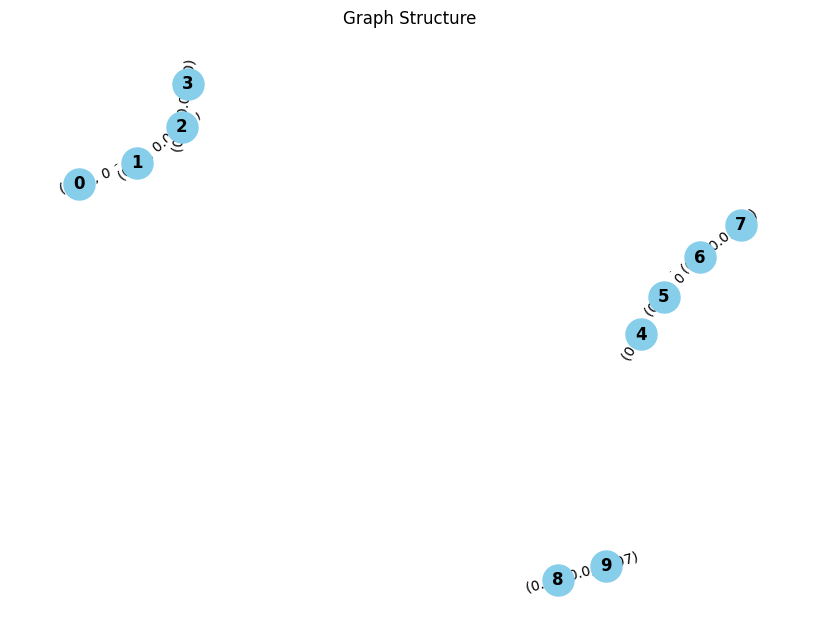

Data(x=[10, 277, 10], edge_index=[2, 7], edge_attr=[7, 3], y=[1, 277, 20], global_input=[1, 277, 4])
Targets: torch.Size([277, 20])
Targets: torch.Size([10, 277, 2])


In [ ]:
if VISUAILIZE_GRAPH:
    inputs_temp, targets_temp = dataset_aircraft[0]
    graph = create_graph(inputs_temp, targets_temp)
    visualize_graph(graph)
    print(graph)

    print("Targets:" , targets_temp.shape)
    targets_temp = targets_temp.unsqueeze(0).reshape(10, -1, 2)
    print("Targets:" , targets_temp.shape)

## Define parameters

In [ ]:
# Constants
EPOCHS = 2500
BATCH_SIZE = 1           # Batch size of 1 is used because of hardware limitations
LEARNING_RATE = 2e-4

In [ ]:
# Create graph dataset
graph_dataset = GraphDataset(dataset_aircraft)

# Initialize Pre-Trained Models
pretrained_wing = wing_model_static
pretrained_canard = wing_model_static
pretrained_rotor1 = rotor1_model
pretrained_rotor2 = rotor2_model
pretrained_rotor3 = rotor3_model
pretrained_rotor4 = rotor4_model


# Ensure all parameters are non-trainable
for param in pretrained_wing.parameters():
    param.requires_grad = False

for param in pretrained_canard.parameters():
    param.requires_grad = False

for param in pretrained_rotor1.parameters():
    param.requires_grad = False

for param in pretrained_rotor2.parameters():
    param.requires_grad = False

for param in pretrained_rotor3.parameters():
    param.requires_grad = False

for param in pretrained_rotor4.parameters():
    param.requires_grad = False


In [ ]:
# Define the split ratio
train_ratio = 0.7
val_ratio = 1-train_ratio

# Calculate split sizes
dataset_size = len(graph_dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
train_dataset_aircraft, val_dataset_aircraft = random_split(graph_dataset, [train_size, val_size])

print("Train Dataset Size:", len(train_dataset_aircraft))
print("Validation Dataset Size:", len(val_dataset_aircraft))

train_dataloader = DataLoader(train_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)


Train Dataset Size: 29
Validation Dataset Size: 13


In [ ]:
hidden_dim = 200
global_input_dim = dataset_aircraft.data["time_varying_inputs"].shape[-1]
edge_input_dim = 3 
output_dim = 2      # Outputs per node


# Instantiate the model
model = HierarchicalCompositeGNN(
                                    pretrained_wing=pretrained_wing,
                                    pretrained_canard=pretrained_canard,
                                    pretrained_rotorL1=pretrained_rotor1,
                                    pretrained_rotorL2=pretrained_rotor2,
                                    pretrained_rotorL3=pretrained_rotor3,
                                    pretrained_rotorL4=pretrained_rotor4,
                                    global_input_dim=global_input_dim,
                                    edge_input_dim=edge_input_dim,
                                    hidden_dim=hidden_dim,
                                    output_dim=output_dim,
                                    lstm_hidden_dim=100,
                                    gat_hidden_dim=hidden_dim,
                                    heads=4,
                                    dropout=0.3
                                ).to(device)


# Define optimizer and loss function
optimizer_composite = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function
criterion = nn.MSELoss()




## Train the model

In [ ]:
if TRAIN_MODEL:

    train_losses = []
    eval_losses = []

    print("[INFO] training the network...")

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        for graph_batch in train_dataloader:
                
            node_inputs = (graph_batch.x).to(device)
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            global_inputs = graph_batch.global_input
            targets = (graph_batch.y).to(device)

            node_inputs = node_inputs.to(device)
            edge_index = edge_index.to(device)
            edge_attr = edge_attr.to(device)
            global_inputs = global_inputs.to(device)

            # Zero the parameter gradients
            optimizer_composite.zero_grad()
            
            # Forward pass
            outputs = model(node_inputs, targets, edge_index, edge_attr, global_inputs, batch_size=BATCH_SIZE, num_nodes=10)
            
            # Compute loss
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer_composite.step()

            running_loss += loss.item()
        avg_train_loss = running_loss/len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Evaluation loop
        model.eval()
        eval_loss = 0.0

        with torch.no_grad():

            for graph_batch in val_dataloader:
                        
                node_inputs = (graph_batch.x).to(device)
                edge_index = graph_batch.edge_index
                edge_attr = graph_batch.edge_attr
                global_inputs = graph_batch.global_input
                targets = (graph_batch.y).to(device)

                node_inputs = node_inputs.to(device)
                edge_index = edge_index.to(device)
                edge_attr = edge_attr.to(device)
                global_inputs = global_inputs.to(device)

                # Forward pass
                outputs = model(node_inputs, targets, edge_index, edge_attr, global_inputs, batch_size=BATCH_SIZE, num_nodes=10)

                # Compute loss
                loss = criterion(outputs, targets)

                eval_loss += loss.item()

            avg_eval_loss = eval_loss / len(val_dataloader)
            eval_losses.append(avg_eval_loss)


        
        print(f'Epoch [{epoch+1}/{EPOCHS}],\n Training Loss: {running_loss/len(train_dataloader):.8f}')
        print(f'Evaluation Loss: {eval_loss/len(val_dataloader):.8f}')

        

    print("[INFO] Finished training the network...")

[INFO] training the network...
Epoch [1/2500],
 Training Loss: 0.04556412
Evaluation Loss: 0.00182834
Epoch [2/2500],
 Training Loss: 0.00212027
Evaluation Loss: 0.00055022
Epoch [3/2500],
 Training Loss: 0.00103763
Evaluation Loss: 0.00058366
Epoch [4/2500],
 Training Loss: 0.00048760
Evaluation Loss: 0.00028533
Epoch [5/2500],
 Training Loss: 0.00029967
Evaluation Loss: 0.00011088
Epoch [6/2500],
 Training Loss: 0.00032797
Evaluation Loss: 0.00021426
Epoch [7/2500],
 Training Loss: 0.00025676
Evaluation Loss: 0.00021628
Epoch [8/2500],
 Training Loss: 0.00016803
Evaluation Loss: 0.00050154
Epoch [9/2500],
 Training Loss: 0.00027423
Evaluation Loss: 0.00013888
Epoch [10/2500],
 Training Loss: 0.00011762
Evaluation Loss: 0.00015498
Epoch [11/2500],
 Training Loss: 0.00040637
Evaluation Loss: 0.00014685
Epoch [12/2500],
 Training Loss: 0.00011889
Evaluation Loss: 0.00009709
Epoch [13/2500],
 Training Loss: 0.00032877
Evaluation Loss: 0.00030256
Epoch [14/2500],
 Training Loss: 0.0002362

## Plot the training loss

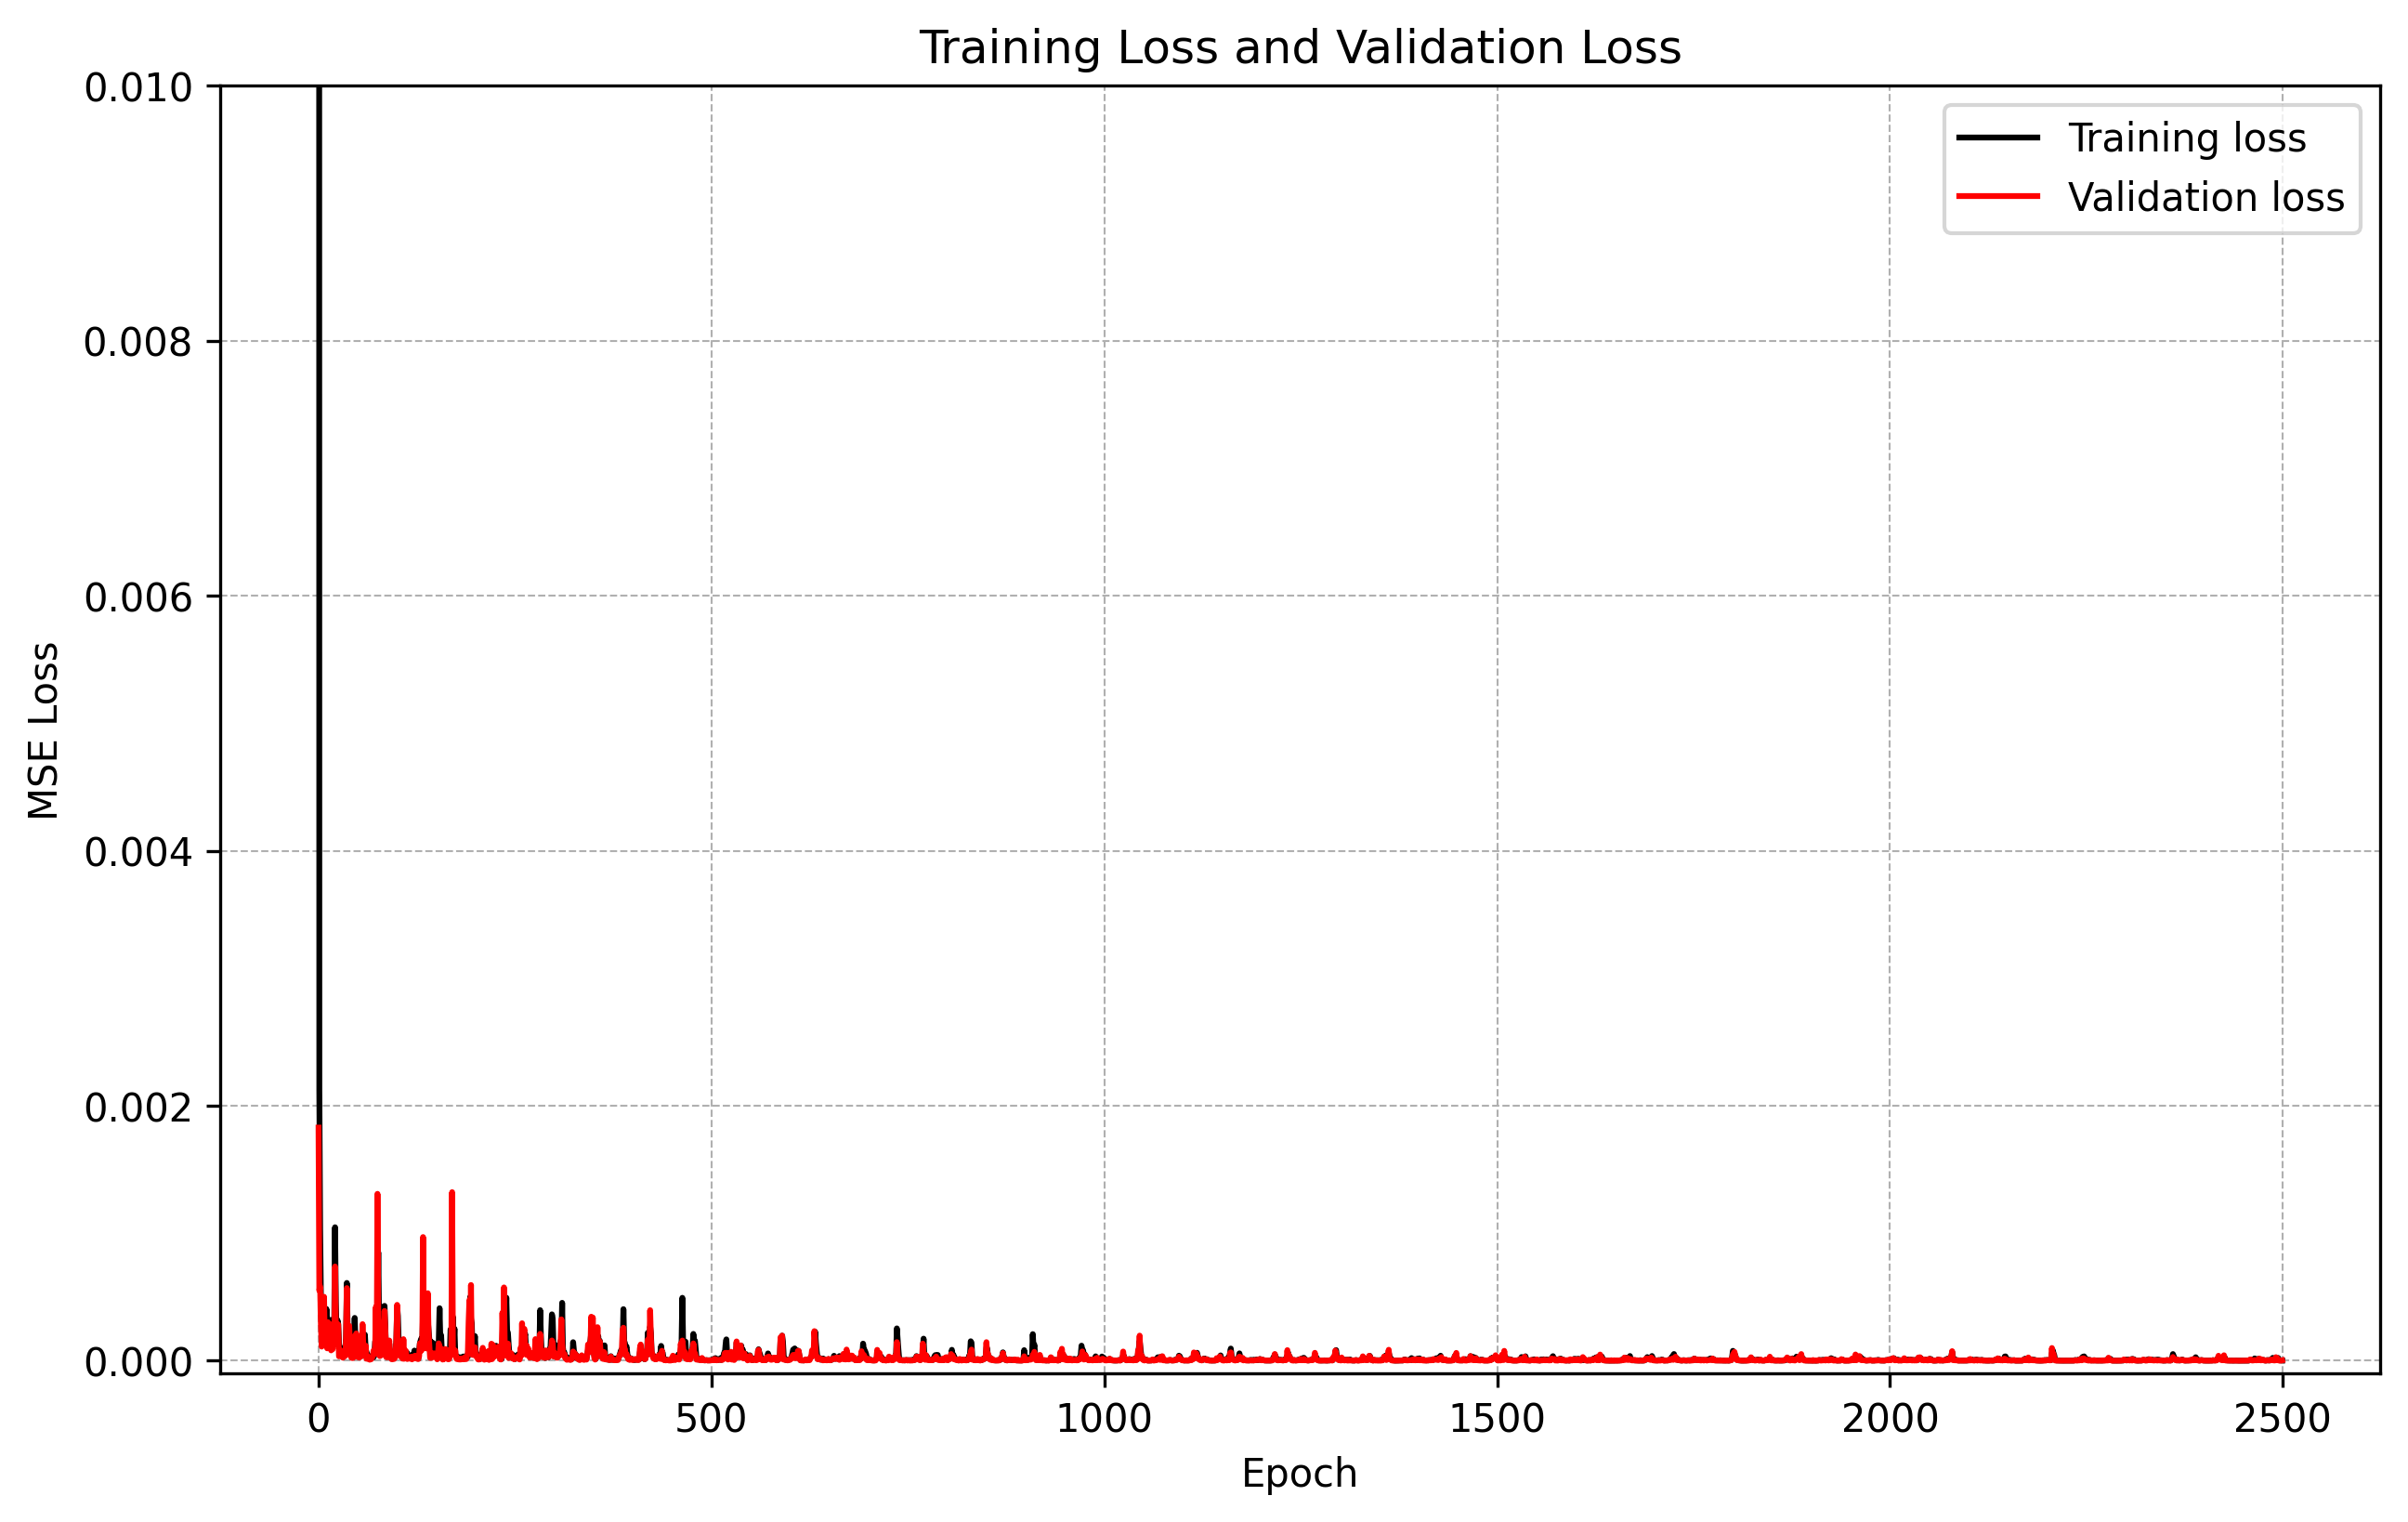

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)  # High-resolution plot

plt.plot((train_losses), color='black', linewidth=1.5, label="Training loss")
plt.plot((eval_losses), color='red', linewidth=1.5, label="Validation loss")
plt.title("Training Loss and Validation Loss", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel("Epoch", fontsize=10)
plt.ylabel("MSE Loss", fontsize=10)
plt.legend(loc='upper right', fontsize=10)
plt.ylim(-0.0001, 0.01)
# plt.savefig("aircraft_model_loss.pdf", format="pdf", dpi=300, bbox_inches="tight")

## Save the model and scalers

In [ ]:
if SAVE_TRAINED_MODEL:

    import datetime
    date = datetime.date.today()

    # Save Python model

    save_path =  project_path + '/trained_models/models/vehicle/{}_aircraft_mseLoss_arch2_lr{}_e{}_hidDim{}.pth'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
    print("The model will be saved as the following:\n {}".format(save_path))


    torch.save(model.state_dict(), save_path)

    # Save the input and output scalers

    wing_input_scaler_path =  project_path + '/trained_models/scalers/vehicle/{}_wing_input_scaler_mseLoss_arch2_lr{}_e{}_hidDim{}.joblib'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
    wing_output_scaler_path = project_path + '/trained_models/scalers/vehicle/{}_wing_output_scaler_mseLoss_arch2_lr{}_e{}_hidDim{}.joblib'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)

    canard_input_scaler_path =  project_path + '/trained_models/scalers/vehicle/{}_canard_input_scaler_mseLoss_arch2_lr{}_e{}_hidDim{}.joblib'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
    canard_output_scaler_path = project_path + '/trained_models/scalers/vehicle/{}_canard_output_scaler_mseLoss_arch2_lr{}_e{}_hidDim{}.joblib'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)

    joblib.dump(input_scaler_wing_temp, wing_input_scaler_path)
    joblib.dump(output_scaler_wing_temp, wing_output_scaler_path)

    joblib.dump(input_scaler_canard_temp, canard_input_scaler_path)
    joblib.dump(output_scaler_canard_temp, canard_output_scaler_path)

## Test the model

In [33]:
def plot_and_save_model_vs_ground_truth(time, model_outputs, ground_truths, aoa, v_inf, simulation_case, save_csv=False, csv_filename="NN_predictions.csv", save_path="./plots/"):
    """
    Plot model predictions vs ground truth for aerodynamic coefficients with professional formatting and save the plots.
    Optionally saves the NN predictions to a CSV file.

    Args:
        time (array-like): Time steps.
        model_outputs (dict): Dictionary containing model predictions.
        ground_truths (dict): Dictionary containing ground truth values.
        aoa (float): Angle of attack in degrees.
        v_inf (float): Free-stream velocity in m/s.
        simulation_case (str): Unique identifier for the simulation case (used in filenames).
        save_csv (bool): If True, saves predictions to a CSV file.
        csv_filename (str): Name of the CSV file to save predictions.
        save_path (str): Directory where plots should be saved.
    """
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Define categories with specific labels
    categories = {
        f"wing_{simulation_case}": [("Cl_Wing", "Lift Coefficient, $C_L$"), ("Cd_Wing", "Drag Coefficient, $C_D$")],
        f"canard_{simulation_case}": [("Cl_Canard", "Lift Coefficient, $C_L$"), ("Cd_Canard", "Drag Coefficient, $C_D$")],
        f"rotorsL_{simulation_case}": [
            ("Ct_L1", "Thrust Coefficient, $C_T$"), ("Cq_L1", "Torque Coefficient, $C_Q$"),
            ("Ct_L2", "Thrust Coefficient, $C_T$"), ("Cq_L2", "Torque Coefficient, $C_Q$"),
            ("Ct_L3", "Thrust Coefficient, $C_T$"), ("Cq_L3", "Torque Coefficient, $C_Q$"),
            ("Ct_L4", "Thrust Coefficient, $C_T$"), ("Cq_L4", "Torque Coefficient, $C_Q$")
        ],
        f"rotorsR_{simulation_case}": [
            ("Ct_R1", "Thrust Coefficient, $C_T$"), ("Cq_R1", "Torque Coefficient, $C_Q$"),
            ("Ct_R2", "Thrust Coefficient, $C_T$"), ("Cq_R2", "Torque Coefficient, $C_Q$"),
            ("Ct_R3", "Thrust Coefficient, $C_T$"), ("Cq_R3", "Torque Coefficient, $C_Q$"),
            ("Ct_R4", "Thrust Coefficient, $C_T$"), ("Cq_R4", "Torque Coefficient, $C_Q$")
        ]
    }

    # Create a dictionary to store CSV data
    csv_data = {"Time": time}

    # Iterate through categories and create separate figures with professional formatting
    for filename, labels in categories.items():
        num_plots = len(labels)
        rows, cols = (num_plots // 2, 2) if num_plots > 2 else (1, num_plots)

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten() if num_plots > 1 else [axes]  # Ensure iterable axes

        for i, (key, ylabel) in enumerate(labels):
            ax = axes[i]
            ax.plot(time, model_outputs[key], label=f'Predicted {ylabel}', color='black', linestyle='--', linewidth=2)
            ax.plot(time, ground_truths[key], label=f'Actual {ylabel}', color='red', linestyle='-', linewidth=2)
            ax.set_xlabel('Time [s]', fontsize=12)
            ax.set_ylabel(ylabel, fontsize=12)
            ax.set_title(f'{ylabel} Comparison', fontsize=14)
            ax.legend(
                loc='upper center', fontsize=10,
                title=f'$AoA$ = ${aoa}^{{\circ}}$, $V_{{\infty}}$ = ${v_inf}$ m/s',
                fancybox=True, borderpad=1, title_fontsize='12', ncol=2
            )
            ax.grid(True, linestyle='--', linewidth=0.5)

            # Set y-limits dynamically based on the data range
            y_min = min(np.min(model_outputs[key]), np.min(ground_truths[key])) - 0.05 * np.abs(np.min(model_outputs[key]))
            y_max = max(np.max(model_outputs[key]), np.max(ground_truths[key])) + 0.05 * np.abs(np.max(model_outputs[key]))
            ax.set_ylim([y_min, y_max])

            # Store data for CSV
            csv_data[f"{key}_NN"] = model_outputs[key]
            csv_data[f"{key}_Truth"] = ground_truths[key]

        plt.tight_layout()
        plot_filename = os.path.join(save_path, f"{filename}.pdf")
        plt.savefig(plot_filename, format="pdf", dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Plot saved: {plot_filename}")

    # Save predictions to CSV if enabled
    if save_csv:
        df = pd.DataFrame(csv_data)
        csv_filepath = os.path.join(save_path, csv_filename)
        df.to_csv(csv_filepath, index=False)
        print(f"Neural Network predictions saved to '{csv_filepath}'")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def mape(y_true, y_pred):
    """Compute Mean Absolute Percentage Error (MAPE)"""
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def relative_l2_norm(y_true, y_pred):
    """Compute Relative L2 Norm Error (ε)"""
    mask = y_true != 0  # Avoid division by zero
    numerator = np.linalg.norm(y_pred[mask] - y_true[mask], ord=2)  # ||pred - true||_2
    denominator = np.linalg.norm(y_true[mask], ord=2)  # ||true||_2
    return (numerator / denominator) * 100

epsilon_wing_cl_list, epsilon_wing_cd_list = [], []
epsilon_canard_cl_list, epsilon_canard_cd_list = [], []
epsilon_r1_ct_list, epsilon_r1_cq_list = [], []
epsilon_r2_ct_list, epsilon_r2_cq_list = [], []
epsilon_r3_ct_list, epsilon_r3_cq_list = [], []
epsilon_r4_ct_list, epsilon_r4_cq_list = [], []
epsilon_l1_ct_list, epsilon_l1_cq_list = [], []
epsilon_l2_ct_list, epsilon_l2_cq_list = [], []
epsilon_l3_ct_list, epsilon_l3_cq_list = [], []
epsilon_l4_ct_list, epsilon_l4_cq_list = [], []

epsilon_wing_list = []
epsilon_canard_list = []
epsilon_r1_list = []
epsilon_r2_list = []
epsilon_r3_list = []
epsilon_r4_list = []
epsilon_l1_list = []
epsilon_l2_list = []
epsilon_l3_list = []
epsilon_l4_list = []

r2_wing_cl_list, r2_wing_cd_list = [], []
r2_canard_cl_list, r2_canard_cd_list = [], []
r2_r1_ct_list, r2_r1_cq_list = [], []
r2_r2_ct_list, r2_r2_cq_list = [], []
r2_r3_ct_list, r2_r3_cq_list = [], []
r2_r4_ct_list, r2_r4_cq_list = [], []
r2_l1_ct_list, r2_l1_cq_list = [], []
r2_l2_ct_list, r2_l2_cq_list = [], []
r2_l3_ct_list, r2_l3_cq_list = [], []
r2_l4_ct_list, r2_l4_cq_list = [], []

r2_wing_list = []
r2_canard_list = []
r2_r1_list = []
r2_r2_list = []
r2_r3_list = []
r2_r4_list = []
r2_l1_list = []
r2_l2_list = []
r2_l3_list = []
r2_l4_list = []


# Initialize lists to store evaluation results
mape_wing_cl_list, mape_wing_cd_list = [], []
mape_canard_cl_list, mape_canard_cd_list = [], []
mape_r1_ct_list, mape_r1_cq_list = [], []
mape_r2_ct_list, mape_r2_cq_list = [], []
mape_r3_ct_list, mape_r3_cq_list = [], []
mape_r4_ct_list, mape_r4_cq_list = [], []
mape_l1_ct_list, mape_l1_cq_list = [], []
mape_l2_ct_list, mape_l2_cq_list = [], []
mape_l3_ct_list, mape_l3_cq_list = [], []
mape_l4_ct_list, mape_l4_cq_list = [], []

mape_wing_list = []
mape_canard_list = []
mape_r1_list = []
mape_r2_list = []
mape_r3_list = []
mape_r4_list = []
mape_l1_list = []
mape_l2_list = []
mape_l3_list = []
mape_l4_list = []

simulation_case_list = []


root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/testing_data/'
batch_size_test = 1

for simulation_case in os.listdir(root_test_base):

    root_test_dir = root_test_base+simulation_case

    # Canard dataset
    dataset_canard_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_canard_test, outputs_canard_test = dataset_canard_test[0:]

    input_tensor_canard_test = inputs_canard_test
    input_tensor_canard_test = inputs_canard_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_canard_test = outputs_canard_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape)

    dataset_wing_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)
    
    inputs_wing_test, outputs_wing_test = dataset_wing_test[0:]

    input_tensor_wing_test = inputs_wing_test
    input_tensor_wing_test = inputs_wing_test.squeeze(1)  # Reshaping
    # print("Input shape (Wing dataset):", input_tensor_wing.shape)
    output_tensor_wing_test = outputs_wing_test.squeeze(1)
    # print("Output shape (Wing dataset):",output_tensor_wing.shape)


    # dataset - Rotor L1
    dataset_rotor_L1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL1_test, outputs_rL1_test = dataset_rotor_L1_test[0:]

    input_tensor_rL1_test = inputs_rL1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - L1):", input_tensor_rL1.shape) 
    output_tensor_rL1_test = outputs_rL1_test.squeeze(1)
    # print("Output shape (rotor - L1):",output_tensor_rL1.shape)

    dataset_rotor_L2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL2_test, outputs_rL2_test = dataset_rotor_L2_test[0:]

    input_tensor_rL2_test = inputs_rL2_test.squeeze(1)  # Reshaping
    output_tensor_rL2_test = outputs_rL2_test.squeeze(1)

    dataset_rotor_L3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL3_test, outputs_rL3_test = dataset_rotor_L3_test[0:]

    input_tensor_rL3_test = inputs_rL3_test.squeeze(1)  # Reshaping
    output_tensor_rL3_test = outputs_rL3_test.squeeze(1)

    dataset_rotor_L4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL4_test, outputs_rL4_test = dataset_rotor_L4_test[0:]

    input_tensor_rL4_test = inputs_rL4_test.squeeze(1)  # Reshaping
    output_tensor_rL4_test = outputs_rL4_test.squeeze(1)

    # dataset - Rotor R1
    dataset_rotor_R1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR1_test, outputs_rR1_test = dataset_rotor_R1_test[0:]

    input_tensor_rR1_test = inputs_rR1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - R1):", input_tensor_rR1.shape) 
    output_tensor_rR1_test = outputs_rR1_test.squeeze(1)
    # print("Output shape (rotor - R1):",output_tensor_rR1.shape) 

    dataset_rotor_R2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR2_test, outputs_rR2_test = dataset_rotor_R2_test[0:]

    input_tensor_rR2_test = inputs_rR2_test.squeeze(1)  # Reshaping
    output_tensor_rR2_test = outputs_rR2_test.squeeze(1)

    dataset_rotor_R3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR3_test, outputs_rR3_test = dataset_rotor_R3_test[0:]

    input_tensor_rR3_test = inputs_rR3_test.squeeze(1)  # Reshaping
    output_tensor_rR3_test = outputs_rR3_test.squeeze(1)

    dataset_rotor_R4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR4_test, outputs_rR4_test = dataset_rotor_R4_test[0:]
    
    input_tensor_rR4_test = inputs_rR4_test.squeeze(1)  # Reshaping
    output_tensor_rR4_test = outputs_rR4_test.squeeze(1)

    dataset_aircraft_test = AircraftDataset(dataset_wing_test,
                                            dataset_canard_test,
                                            dataset_rotor_L1_test,
                                            dataset_rotor_L2_test,
                                            dataset_rotor_L3_test,
                                            dataset_rotor_L4_test,
                                            dataset_rotor_R1_test,
                                            dataset_rotor_R2_test,
                                            dataset_rotor_R3_test,
                                            dataset_rotor_R4_test,
                                            input_scaler_wing_temp,
                                            output_scaler_wing_temp,
                                            input_scaler_canard_temp,
                                            output_scaler_canard_temp,
                                            input_scaler_rotor1, output_scaler_rotor1,
                                            input_scaler_rotor2, output_scaler_rotor2,
                                            input_scaler_rotor3, output_scaler_rotor3,
                                            input_scaler_rotor4, output_scaler_rotor4)


    graph_dataset_test = GraphDataset(dataset_aircraft_test)

    graph_dataset_test = graph_dataset_test[0]

    node_inputs_test = (graph_dataset_test.x).to(device)
    edge_index_test = (graph_dataset_test.edge_index).to(device)
    edge_attr_test = (graph_dataset_test.edge_attr).to(device)
    global_inputs_test = (graph_dataset_test.global_input).to(device)
    targets_test = (graph_dataset_test.y).to(device)
    # targets_test = (graph_dataset_test.y).reshape(10, -1, 2).to(device)

    model.eval()  # Set the model to evaluation mode


    with torch.no_grad():
        # outputs_predicted = scripted_model(node_inputs_test, targets_test, edge_index_test,
        #                                      edge_attr_test, global_inputs_test,
        #                                      batch_size_test, num_nodes=10)
        
        outputs_predicted = model(node_inputs_test, targets_test, edge_index_test, edge_attr_test, global_inputs_test, batch_size_test, num_nodes=10)

    
    
    outputs_predicted = outputs_predicted.cpu().detach().numpy()  # Convert tensor to numpy array
    # print("Predicted Outputs Shape:", outputs_predicted.shape)
    outputs_predicted = outputs_predicted.squeeze(0)

    predicted_outputs_canard = outputs_predicted[:, 16:18]
    predicted_outputs_wing = outputs_predicted[:, 18:20]
    predicted_outputs_rotor_L1 = outputs_predicted[:, 0:2]
    predicted_outputs_rotor_R1 = outputs_predicted[:, 8:10]
    predicted_outputs_rotor_L2 = outputs_predicted[:, 2:4]
    predicted_outputs_rotor_R2 = outputs_predicted[:, 10:12]
    predicted_outputs_rotor_L3 = outputs_predicted[:, 4:6]
    predicted_outputs_rotor_R3 = outputs_predicted[:, 12:14]
    predicted_outputs_rotor_L4 = outputs_predicted[:, 6:8]
    predicted_outputs_rotor_R4 = outputs_predicted[:, 14:16]
    
    # Inverse scaling
    predicted_outputs_canard_og_scl = output_scaler_canard_temp.inverse_transform(predicted_outputs_canard)
    predicted_outputs_wing_og_scl = output_scaler_wing_temp.inverse_transform(predicted_outputs_wing)
    predicted_outputs_rotor_L1_og_scl = output_scaler_rotor1.inverse_transform(predicted_outputs_rotor_L1)
    predicted_outputs_rotor_R1_og_scl = output_scaler_rotor1.inverse_transform(predicted_outputs_rotor_R1)
    predicted_outputs_rotor_L2_og_scl = output_scaler_rotor2.inverse_transform(predicted_outputs_rotor_L2)
    predicted_outputs_rotor_R2_og_scl = output_scaler_rotor2.inverse_transform(predicted_outputs_rotor_R2)
    predicted_outputs_rotor_L3_og_scl = output_scaler_rotor3.inverse_transform(predicted_outputs_rotor_L3)
    predicted_outputs_rotor_R3_og_scl = output_scaler_rotor3.inverse_transform(predicted_outputs_rotor_R3)
    predicted_outputs_rotor_L4_og_scl = output_scaler_rotor4.inverse_transform(predicted_outputs_rotor_L4)
    predicted_outputs_rotor_R4_og_scl = output_scaler_rotor4.inverse_transform(predicted_outputs_rotor_R4)

    # time_steps = time_steps.cpu().detach().numpy()
    time_steps = (global_inputs_test.squeeze(0))[:,0]
    time_steps = time_steps.cpu().detach().numpy()

    # Predictions from the Neural Network
    cl_test_NN_wing = predicted_outputs_wing_og_scl[:, 0]
    cd_test_NN_wing = predicted_outputs_wing_og_scl[:, 1]

    cl_test_NN_canard = predicted_outputs_canard_og_scl[:, 0]
    cd_test_NN_canard = predicted_outputs_canard_og_scl[:, 1]

    ct_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 0]
    cq_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 1]

    ct_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 0]
    cq_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 1]
    
    ct_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 0]
    cq_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 1]

    ct_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 0]
    cq_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 1]

    ct_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 0]
    cq_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 1]

    ct_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 0]
    cq_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 1]

    ct_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 0]
    cq_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 1]

    ct_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 0]
    cq_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 1]

    
    # FLOWUnsteady dataset
    cl_test_flowuns_canard = dataset_canard_test.get_variable('CL')
    cd_test_flowuns_canard = dataset_canard_test.get_variable('CD')
    cl_test_flowuns_wing = dataset_wing_test.get_variable('CL')
    cd_test_flowuns_wing = dataset_wing_test.get_variable('CD')
    ct_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CT')
    cq_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CQ')
    ct_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CT')
    cq_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CQ')
    ct_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CT')
    cq_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CQ')
    ct_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CT')
    cq_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CQ')
    ct_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CT')
    cq_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CQ')
    ct_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CT')
    cq_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CQ')
    ct_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CT')
    cq_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CQ')
    ct_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CT')
    cq_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CQ')

    ct_test_flowuns_L1 = align_timesteps(ct_test_flowuns_L1[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L1 = align_timesteps(cq_test_flowuns_L1[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_L2 = align_timesteps(ct_test_flowuns_L2[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L2 = align_timesteps(cq_test_flowuns_L2[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_L3 = align_timesteps(ct_test_flowuns_L3[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L3 = align_timesteps(cq_test_flowuns_L3[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_L4 = align_timesteps(ct_test_flowuns_L4[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L4 = align_timesteps(cq_test_flowuns_L4[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R1 = align_timesteps(ct_test_flowuns_R1[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R1 = align_timesteps(cq_test_flowuns_R1[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R2 = align_timesteps(ct_test_flowuns_R2[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R2 = align_timesteps(cq_test_flowuns_R2[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R3 = align_timesteps(ct_test_flowuns_R3[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R3 = align_timesteps(cq_test_flowuns_R3[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R4 = align_timesteps(ct_test_flowuns_R4[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R4 = align_timesteps(cq_test_flowuns_R4[0][np.newaxis, :], len(time_steps))
    # shape = ct_test_flowuns_L1.shape

    print(len(ct_test_flowuns_L1))

    # ct_test_flowuns_L1 = align_timesteps(ct_test_flowuns_L1, len(time_steps))

    model_outputs = {
        "Cl_Wing": cl_test_NN_wing,
        "Cd_Wing": cd_test_NN_wing,
        "Cl_Canard": cl_test_NN_canard,
        "Cd_Canard": cd_test_NN_canard,
        "Ct_L1": ct_test_NN_L1,
        "Cq_L1": cq_test_NN_L1,
        "Ct_L2": ct_test_NN_L2,
        "Cq_L2": cq_test_NN_L2,
        "Ct_L3": ct_test_NN_L3,
        "Cq_L3": cq_test_NN_L3,
        "Ct_L4": ct_test_NN_L4,
        "Cq_L4": cq_test_NN_L4,
        "Ct_R1": ct_test_NN_R1,
        "Cq_R1": cq_test_NN_R1,
        "Ct_R2": ct_test_NN_R2,
        "Cq_R2": cq_test_NN_R2,
        "Ct_R3": ct_test_NN_R3,
        "Cq_R3": cq_test_NN_R3,
        "Ct_R4": ct_test_NN_R4,
        "Cq_R4": cq_test_NN_R4,
    }

    ground_truths = {
        "Cl_Wing": cl_test_flowuns_wing[0],
        "Cd_Wing": cd_test_flowuns_wing[0],
        "Cl_Canard": cl_test_flowuns_canard[0],
        "Cd_Canard": cd_test_flowuns_canard[0],
        "Ct_L1": ct_test_flowuns_L1[0],
        "Cq_L1": cq_test_flowuns_L1[0],
        "Ct_L2": ct_test_flowuns_L2[0],
        "Cq_L2": cq_test_flowuns_L2[0],
        "Ct_L3": ct_test_flowuns_L3[0],
        "Cq_L3": cq_test_flowuns_L3[0], 
        "Ct_L4": ct_test_flowuns_L4[0],
        "Cq_L4": cq_test_flowuns_L4[0],
        "Ct_R1": ct_test_flowuns_R1[0],
        "Cq_R1": cq_test_flowuns_R1[0],
        "Ct_R2": ct_test_flowuns_R2[0],
        "Cq_R2": cq_test_flowuns_R2[0],
        "Ct_R3": ct_test_flowuns_R3[0],
        "Cq_R3": cq_test_flowuns_R3[0],
        "Ct_R4": ct_test_flowuns_R4[0],
        "Cq_R4": cq_test_flowuns_R4[0],
    }

    # List of labels for plotting
    labels = list(model_outputs.keys())  # Ensures ordering matches

    # Calculate MAPE
    mape_wing_cl = mape(ground_truths["Cl_Wing"], model_outputs["Cl_Wing"])
    mape_wing_cd = mape(ground_truths["Cd_Wing"], model_outputs["Cd_Wing"])
    mape_canard_cl = mape(ground_truths["Cl_Canard"], model_outputs["Cl_Canard"])
    mape_canard_cd = mape(ground_truths["Cd_Canard"], model_outputs["Cd_Canard"])
    mape_r1_ct = mape(ground_truths["Ct_R1"], model_outputs["Ct_R1"])
    mape_r1_cq = mape(ground_truths["Cq_R1"], model_outputs["Cq_R1"])
    mape_r2_ct = mape(ground_truths["Ct_R2"], model_outputs["Ct_R2"])
    mape_r2_cq = mape(ground_truths["Cq_R2"], model_outputs["Cq_R2"])
    mape_r3_ct = mape(ground_truths["Ct_R3"], model_outputs["Ct_R3"])
    mape_r3_cq = mape(ground_truths["Cq_R3"], model_outputs["Cq_R3"])
    mape_r4_ct = mape(ground_truths["Ct_R4"], model_outputs["Ct_R4"])
    mape_r4_cq = mape(ground_truths["Cq_R4"], model_outputs["Cq_R4"])
    mape_l1_ct = mape(ground_truths["Ct_L1"], model_outputs["Ct_L1"])
    mape_l1_cq = mape(ground_truths["Cq_L1"], model_outputs["Cq_L1"])   
    mape_l2_ct = mape(ground_truths["Ct_L2"], model_outputs["Ct_L2"])
    mape_l2_cq = mape(ground_truths["Cq_L2"], model_outputs["Cq_L2"])
    mape_l3_ct = mape(ground_truths["Ct_L3"], model_outputs["Ct_L3"])
    mape_l3_cq = mape(ground_truths["Cq_L3"], model_outputs["Cq_L3"])
    mape_l4_ct = mape(ground_truths["Ct_L4"], model_outputs["Ct_L4"])
    mape_l4_cq = mape(ground_truths["Cq_L4"], model_outputs["Cq_L4"])

    mape_wing_cl_list.append(mape_wing_cl)
    mape_wing_cd_list.append(mape_wing_cd)
    mape_canard_cl_list.append(mape_canard_cl)
    mape_canard_cd_list.append(mape_canard_cd)
    mape_r1_ct_list.append(mape_r1_ct)
    mape_r1_cq_list.append(mape_r1_cq)
    mape_r2_ct_list.append(mape_r2_ct)
    mape_r2_cq_list.append(mape_r2_cq)
    mape_r3_ct_list.append(mape_r3_ct)
    mape_r3_cq_list.append(mape_r3_cq)
    mape_r4_ct_list.append(mape_r4_ct)
    mape_r4_cq_list.append(mape_r4_cq)
    mape_l1_ct_list.append(mape_l1_ct)
    mape_l1_cq_list.append(mape_l1_cq)
    mape_l2_ct_list.append(mape_l2_ct)
    mape_l2_cq_list.append(mape_l2_cq)
    mape_l3_ct_list.append(mape_l3_ct)
    mape_l3_cq_list.append(mape_l3_cq)
    mape_l4_ct_list.append(mape_l4_ct)
    mape_l4_cq_list.append(mape_l4_cq)

    mape_wing = (mape_wing_cl + mape_wing_cd) / 2
    mape_canard = (mape_canard_cl + mape_canard_cd) / 2
    mape_r1 = (mape_r1_ct + mape_r1_cq) / 2
    mape_r2 = (mape_r2_ct + mape_r2_cq) / 2
    mape_r3 = (mape_r3_ct + mape_r3_cq) / 2
    mape_r4 = (mape_r4_ct + mape_r4_cq) / 2
    mape_l1 = (mape_l1_ct + mape_l1_cq) / 2
    mape_l2 = (mape_l2_ct + mape_l2_cq) / 2
    mape_l3 = (mape_l3_ct + mape_l3_cq) / 2
    mape_l4 = (mape_l4_ct + mape_l4_cq) / 2 

    mape_wing_list.append(mape_wing)
    mape_canard_list.append(mape_canard)
    mape_r1_list.append(mape_r1)
    mape_r2_list.append(mape_r2)
    mape_r3_list.append(mape_r3)
    mape_r4_list.append(mape_r4)
    mape_l1_list.append(mape_l1)
    mape_l2_list.append(mape_l2)
    mape_l3_list.append(mape_l3)
    mape_l4_list.append(mape_l4)


    # Calculate R2
    r2_wing_cl = r2_score(ground_truths["Cl_Wing"], model_outputs["Cl_Wing"])
    r2_wing_cd = r2_score(ground_truths["Cd_Wing"], model_outputs["Cd_Wing"])
    r2_canard_cl = r2_score(ground_truths["Cl_Canard"], model_outputs["Cl_Canard"])
    r2_canard_cd = r2_score(ground_truths["Cd_Canard"], model_outputs["Cd_Canard"])
    r2_r1_ct = r2_score(ground_truths["Ct_R1"], model_outputs["Ct_R1"])
    r2_r1_cq = r2_score(ground_truths["Cq_R1"], model_outputs["Cq_R1"])
    r2_r2_ct = r2_score(ground_truths["Ct_R2"], model_outputs["Ct_R2"])
    r2_r2_cq = r2_score(ground_truths["Cq_R2"], model_outputs["Cq_R2"])
    r2_r3_ct = r2_score(ground_truths["Ct_R3"], model_outputs["Ct_R3"])
    r2_r3_cq = r2_score(ground_truths["Cq_R3"], model_outputs["Cq_R3"])
    r2_r4_ct = r2_score(ground_truths["Ct_R4"], model_outputs["Ct_R4"])
    r2_r4_cq = r2_score(ground_truths["Cq_R4"], model_outputs["Cq_R4"])
    r2_l1_ct = r2_score(ground_truths["Ct_L1"], model_outputs["Ct_L1"])
    r2_l1_cq = r2_score(ground_truths["Cq_L1"], model_outputs["Cq_L1"])
    r2_l2_ct = r2_score(ground_truths["Ct_L2"], model_outputs["Ct_L2"])
    r2_l2_cq = r2_score(ground_truths["Cq_L2"], model_outputs["Cq_L2"])
    r2_l3_ct = r2_score(ground_truths["Ct_L3"], model_outputs["Ct_L3"])
    r2_l3_cq = r2_score(ground_truths["Cq_L3"], model_outputs["Cq_L3"])
    r2_l4_ct = r2_score(ground_truths["Ct_L4"], model_outputs["Ct_L4"])
    r2_l4_cq = r2_score(ground_truths["Cq_L4"], model_outputs["Cq_L4"])

    r2_wing_cl_list.append(r2_wing_cl)
    r2_wing_cd_list.append(r2_wing_cd)
    r2_canard_cl_list.append(r2_canard_cl)
    r2_canard_cd_list.append(r2_canard_cd)
    r2_r1_ct_list.append(r2_r1_ct)
    r2_r1_cq_list.append(r2_r1_cq)
    r2_r2_ct_list.append(r2_r2_ct)
    r2_r2_cq_list.append(r2_r2_cq)
    r2_r3_ct_list.append(r2_r3_ct)
    r2_r3_cq_list.append(r2_r3_cq)
    r2_r4_ct_list.append(r2_r4_ct)
    r2_r4_cq_list.append(r2_r4_cq)
    r2_l1_ct_list.append(r2_l1_ct)
    r2_l1_cq_list.append(r2_l1_cq)
    r2_l2_ct_list.append(r2_l2_ct)
    r2_l2_cq_list.append(r2_l2_cq)
    r2_l3_ct_list.append(r2_l3_ct)
    r2_l3_cq_list.append(r2_l3_cq)
    r2_l4_ct_list.append(r2_l4_ct)
    r2_l4_cq_list.append(r2_l4_cq)

    r2_wing = (r2_wing_cl + r2_wing_cd) / 2
    r2_canard = (r2_canard_cl + r2_canard_cd) / 2
    r2_r1 = (r2_r1_ct + r2_r1_cq) / 2
    r2_r2 = (r2_r2_ct + r2_r2_cq) / 2
    r2_r3 = (r2_r3_ct + r2_r3_cq) / 2
    r2_r4 = (r2_r4_ct + r2_r4_cq) / 2
    r2_l1 = (r2_l1_ct + r2_l1_cq) / 2
    r2_l2 = (r2_l2_ct + r2_l2_cq) / 2
    r2_l3 = (r2_l3_ct + r2_l3_cq) / 2
    r2_l4 = (r2_l4_ct + r2_l4_cq) / 2

    r2_wing_list.append(r2_wing)
    r2_canard_list.append(r2_canard)
    r2_r1_list.append(r2_r1)
    r2_r2_list.append(r2_r2)
    r2_r3_list.append(r2_r3)
    r2_r4_list.append(r2_r4)
    r2_l1_list.append(r2_l1)
    r2_l2_list.append(r2_l2)
    r2_l3_list.append(r2_l3)
    r2_l4_list.append(r2_l4)

    # Calculate relative l2 error
    epsilon_wing_cl = relative_l2_norm(ground_truths["Cl_Wing"], model_outputs["Cl_Wing"])
    epsilon_wing_cd = relative_l2_norm(ground_truths["Cd_Wing"], model_outputs["Cd_Wing"])
    epsilon_canard_cl = relative_l2_norm(ground_truths["Cl_Canard"], model_outputs["Cl_Canard"])
    epsilon_canard_cd = relative_l2_norm(ground_truths["Cd_Canard"], model_outputs["Cd_Canard"])
    epsilon_r1_ct = relative_l2_norm(ground_truths["Ct_R1"], model_outputs["Ct_R1"])
    epsilon_r1_cq = relative_l2_norm(ground_truths["Cq_R1"], model_outputs["Cq_R1"])
    epsilon_r2_ct = relative_l2_norm(ground_truths["Ct_R2"], model_outputs["Ct_R2"])
    epsilon_r2_cq = relative_l2_norm(ground_truths["Cq_R2"], model_outputs["Cq_R2"])
    epsilon_r3_ct = relative_l2_norm(ground_truths["Ct_R3"], model_outputs["Ct_R3"])
    epsilon_r3_cq = relative_l2_norm(ground_truths["Cq_R3"], model_outputs["Cq_R3"])
    epsilon_r4_ct = relative_l2_norm(ground_truths["Ct_R4"], model_outputs["Ct_R4"])
    epsilon_r4_cq = relative_l2_norm(ground_truths["Cq_R4"], model_outputs["Cq_R4"])
    epsilon_l1_ct = relative_l2_norm(ground_truths["Ct_L1"], model_outputs["Ct_L1"])
    epsilon_l1_cq = relative_l2_norm(ground_truths["Cq_L1"], model_outputs["Cq_L1"])
    epsilon_l2_ct = relative_l2_norm(ground_truths["Ct_L2"], model_outputs["Ct_L2"])
    epsilon_l2_cq = relative_l2_norm(ground_truths["Cq_L2"], model_outputs["Cq_L2"])
    epsilon_l3_ct = relative_l2_norm(ground_truths["Ct_L3"], model_outputs["Ct_L3"])
    epsilon_l3_cq = relative_l2_norm(ground_truths["Cq_L3"], model_outputs["Cq_L3"])
    epsilon_l4_ct = relative_l2_norm(ground_truths["Ct_L4"], model_outputs["Ct_L4"])
    epsilon_l4_cq = relative_l2_norm(ground_truths["Cq_L4"], model_outputs["Cq_L4"])

    epsilon_wing_cl_list.append(epsilon_wing_cl)
    epsilon_wing_cd_list.append(epsilon_wing_cd)
    epsilon_canard_cl_list.append(epsilon_canard_cl)
    epsilon_canard_cd_list.append(epsilon_canard_cd)
    epsilon_r1_ct_list.append(epsilon_r1_ct)
    epsilon_r1_cq_list.append(epsilon_r1_cq)
    epsilon_r2_ct_list.append(epsilon_r2_ct)
    epsilon_r2_cq_list.append(epsilon_r2_cq)
    epsilon_r3_ct_list.append(epsilon_r3_ct)
    epsilon_r3_cq_list.append(epsilon_r3_cq)
    epsilon_r4_ct_list.append(epsilon_r4_ct)
    epsilon_r4_cq_list.append(epsilon_r4_cq)
    epsilon_l1_ct_list.append(epsilon_l1_ct)
    epsilon_l1_cq_list.append(epsilon_l1_cq)
    epsilon_l2_ct_list.append(epsilon_l2_ct)
    epsilon_l2_cq_list.append(epsilon_l2_cq)
    epsilon_l3_ct_list.append(epsilon_l3_ct)
    epsilon_l3_cq_list.append(epsilon_l3_cq)
    epsilon_l4_ct_list.append(epsilon_l4_ct)
    epsilon_l4_cq_list.append(epsilon_l4_cq)

    epsilon_wing = (epsilon_wing_cl + epsilon_wing_cd) / 2
    epsilon_canard = (epsilon_canard_cl + epsilon_canard_cd) / 2
    epsilon_r1 = (epsilon_r1_ct + epsilon_r1_cq) / 2
    epsilon_r2 = (epsilon_r2_ct + epsilon_r2_cq) / 2
    epsilon_r3 = (epsilon_r3_ct + epsilon_r3_cq) / 2
    epsilon_r4 = (epsilon_r4_ct + epsilon_r4_cq) / 2
    epsilon_l1 = (epsilon_l1_ct + epsilon_l1_cq) / 2
    epsilon_l2 = (epsilon_l2_ct + epsilon_l2_cq) / 2
    epsilon_l3 = (epsilon_l3_ct + epsilon_l3_cq) / 2
    epsilon_l4 = (epsilon_l4_ct + epsilon_l4_cq) / 2

    epsilon_wing_list.append(epsilon_wing)
    epsilon_canard_list.append(epsilon_canard)
    epsilon_r1_list.append(epsilon_r1)
    epsilon_r2_list.append(epsilon_r2)
    epsilon_r3_list.append(epsilon_r3)
    epsilon_r4_list.append(epsilon_r4)
    epsilon_l1_list.append(epsilon_l1)
    epsilon_l2_list.append(epsilon_l2)
    epsilon_l3_list.append(epsilon_l3)
    epsilon_l4_list.append(epsilon_l4)

    print("Simulation Case:", simulation_case)  
    simulation_case_list = simulation_case.split('_')
    vinf = simulation_case_list[2].split('v')[1]
    rpm = simulation_case_list[3].split('r')[1]
    alpha = simulation_case_list[4].split('a')[1]

    simulation_case_list.append(simulation_case)

    # save_path = root_test_dir + simulation_case + '_NN_predictions.csv'

    print("MAPE Wing CL:", mape_wing_cl, "MAPE Wing CD:", mape_wing_cd, "epsilon Wing CL:", epsilon_wing_cl, "epsilon Wing CD:", epsilon_wing_cd, "R2 Wing CL:", r2_wing_cl, "R2 Wing CD:", r2_wing_cd)
    print("MAPE Canard CL:", mape_canard_cl, "MAPE Canard CD:", mape_canard_cd, "epsilon Canard CL:", epsilon_canard_cl, "epsilon Canard CD:", epsilon_canard_cd, "R2 Canard CL:", r2_canard_cl, "R2 Canard CD:", r2_canard_cd)
    print("MAPE R1 CT:", mape_r1_ct, "MAPE R1 CQ:", mape_r1_cq, "epsilon R1 CT:", epsilon_r1_ct, "epsilon R1 CQ:", epsilon_r1_cq, "R2 R1 CT:", r2_r1_ct, "R2 R1 CQ:", r2_r1_cq)
    print("MAPE R2 CT:", mape_r2_ct, "MAPE R2 CQ:", mape_r2_cq, "epsilon R2 CT:", epsilon_r2_ct, "epsilon R2 CQ:", epsilon_r2_cq, "R2 R2 CT:", r2_r2_ct, "R2 R2 CQ:", r2_r2_cq)
    print("MAPE R3 CT:", mape_r3_ct, "MAPE R3 CQ:", mape_r3_cq, "epsilon R3 CT:", epsilon_r3_ct, "epsilon R3 CQ:", epsilon_r3_cq, "R2 R3 CT:", r2_r3_ct, "R2 R3 CQ:", r2_r3_cq)
    print("MAPE R4 CT:", mape_r4_ct, "MAPE R4 CQ:", mape_r4_cq, "epsilon R4 CT:", epsilon_r4_ct, "epsilon R4 CQ:", epsilon_r4_cq, "R2 R4 CT:", r2_r4_ct, "R2 R4 CQ:", r2_r4_cq)
    print("MAPE L1 CT:", mape_l1_ct, "MAPE L1 CQ:", mape_l1_cq, "epsilon L1 CT:", epsilon_l1_ct, "epsilon L1 CQ:", epsilon_l1_cq, "R2 L1 CT:", r2_l1_ct, "R2 L1 CQ:", r2_l1_cq)
    print("MAPE L2 CT:", mape_l2_ct, "MAPE L2 CQ:", mape_l2_cq, "epsilon L2 CT:", epsilon_l2_ct, "epsilon L2 CQ:", epsilon_l2_cq, "R2 L2 CT:", r2_l2_ct, "R2 L2 CQ:", r2_l2_cq)
    print("MAPE L3 CT:", mape_l3_ct, "MAPE L3 CQ:", mape_l3_cq, "epsilon L3 CT:", epsilon_l3_ct, "epsilon L3 CQ:", epsilon_l3_cq, "R2 L3 CT:", r2_l3_ct, "R2 L3 CQ:", r2_l3_cq)
    print("MAPE L4 CT:", mape_l4_ct, "MAPE L4 CQ:", mape_l4_cq, "epsilon L4 CT:", epsilon_l4_ct, "epsilon L4 CQ:", epsilon_l4_cq, "R2 L4 CT:", r2_l4_ct, "R2 L4 CQ:", r2_l4_cq)

        
    
    # Ensure save directory exists
    save_path = result_out_path+"/new_results/"
    # os.makedirs(save_path, exist_ok=True)
    if PLOT_RESULT:
        plot_and_save_model_vs_ground_truth(time_steps, model_outputs, ground_truths, alpha, vinf, simulation_case, save_csv=False, csv_filename='predictions.csv', save_path=save_path)
        # Plot Thrust Coefficients
        plt.figure(figsize=(15, 5))

        # Ground Truth (FLOWUnsteady)
        plt.subplot(1, 2, 1)
        plt.plot(time_steps, ct_test_flowuns_L1[0], label='Actual $C_T$ L1', color='red', linestyle='-', linewidth=2)
        plt.plot(time_steps, ct_test_flowuns_L2[0], label='Actual $C_T$ L2', color='blue', linestyle='-', linewidth=2)
        plt.plot(time_steps, ct_test_flowuns_L3[0], label='Actual $C_T$ L3', color='green', linestyle='-', linewidth=2)
        plt.plot(time_steps, ct_test_flowuns_L4[0], label='Actual $C_T$ L4', color='purple', linestyle='-', linewidth=2)
        plt.xlabel('Time [s]', fontsize=12)
        plt.ylabel('Thrust Coefficient, $C_T$', fontsize=12)
        plt.title(f'Thrust Coefficient Comparison - FLOWUnsteady', fontsize=14)
        plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
        plt.ylim(ct_test_flowuns_L4[0].min() - 0.003, ct_test_flowuns_L1[0].max() + 0.003)
        # plt.ylim(ct_test_flowuns_L4[0].min() - 0.002, ct_test_flowuns_L1[0].max() + 0.002)
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Predicted (Neural Network)
        plt.subplot(1, 2, 2)
        plt.plot(time_steps, ct_test_NN_L1[0:], label='Predicted $C_T$ L1', color='red', linestyle='--', linewidth=2)
        plt.plot(time_steps, ct_test_NN_L2[0:], label='Predicted $C_T$ L2', color='blue', linestyle='--', linewidth=2)
        plt.plot(time_steps, ct_test_NN_L3[0:], label='Predicted $C_T$ L3', color='green', linestyle='--', linewidth=2)
        plt.plot(time_steps, ct_test_NN_L4[0:], label='Predicted $C_T$ L4', color='purple', linestyle='--', linewidth=2)
        plt.xlabel('Time [s]', fontsize=12)
        plt.ylabel('Thrust Coefficient, $C_T$', fontsize=12)
        plt.title(f'Thrust Coefficient Comparison - NN Model', fontsize=14)
        plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
        plt.ylim(ct_test_flowuns_L4[0].min() - 0.003, ct_test_flowuns_L1[0].max() + 0.003)
        plt.grid(True, linestyle='--', linewidth=0.5)

        plt.tight_layout()
        if SAVE_PLOT:
            thrust_plot_filename = os.path.join(save_path, f"thrust_coefficients_{simulation_case}.pdf")
            plt.savefig(thrust_plot_filename, format="pdf", dpi=300, bbox_inches="tight")
        plt.show()

        # Plot Torque Coefficients
        plt.figure(figsize=(15, 5))

        # Ground Truth (FLOWUnsteady)
        plt.subplot(1, 2, 1)
        plt.plot(time_steps, cq_test_flowuns_L1[0], label='Actual $C_Q$ L1', color='red', linestyle='-', linewidth=2)
        plt.plot(time_steps, cq_test_flowuns_L2[0], label='Actual $C_Q$ L2', color='blue', linestyle='-', linewidth=2)
        plt.plot(time_steps, cq_test_flowuns_L3[0], label='Actual $C_Q$ L3', color='green', linestyle='-', linewidth=2)
        plt.plot(time_steps, cq_test_flowuns_L4[0], label='Actual $C_Q$ L4', color='purple', linestyle='-', linewidth=2)
        plt.xlabel('Time [s]', fontsize=12)
        plt.ylabel('Torque Coefficient, $C_Q$', fontsize=12)
        plt.title(f'Torque Coefficient Comparison - FLOWUnsteady', fontsize=14)
        plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
        plt.ylim(cq_test_flowuns_L4[0].min() - 0.0003, cq_test_flowuns_L1[0].max() + 0.0003)
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Predicted (Neural Network)
        plt.subplot(1, 2, 2)
        plt.plot(time_steps, cq_test_NN_L1[0:], label='Predicted $C_Q$ L1', color='red', linestyle='--', linewidth=2)
        plt.plot(time_steps, cq_test_NN_L2[0:], label='Predicted $C_Q$ L2', color='blue', linestyle='--', linewidth=2)
        plt.plot(time_steps, cq_test_NN_L3[0:], label='Predicted $C_Q$ L3', color='green', linestyle='--', linewidth=2)
        plt.plot(time_steps, cq_test_NN_L4[0:], label='Predicted $C_Q$ L4', color='purple', linestyle='--', linewidth=2)
        plt.xlabel('Time [s]', fontsize=12)
        plt.ylabel('Torque Coefficient, $C_Q$', fontsize=12)
        plt.title(f'Torque Coefficient Comparison - NN Model', fontsize=14)
        plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
        plt.ylim(cq_test_flowuns_L4[0].min() - 0.0003, cq_test_flowuns_L1[0].max() + 0.0003)
        plt.grid(True, linestyle='--', linewidth=0.5)

        plt.tight_layout()
        if SAVE_PLOT:
            torque_plot_filename = os.path.join(save_path, f"torque_coefficients_{simulation_case}.pdf")
            plt.savefig(torque_plot_filename, format="pdf", dpi=300, bbox_inches="tight")
        plt.show()






# Average MAPE
if SAVE_RESULT:
    mape_wing_cl_avg = np.mean(mape_wing_cl_list)
    mape_wing_cd_avg = np.mean(mape_wing_cd_list)   
    mape_canard_cl_avg = np.mean(mape_canard_cl_list)
    mape_canard_cd_avg = np.mean(mape_canard_cd_list)
    mape_r1_ct_avg = np.mean(mape_r1_ct_list)
    mape_r1_cq_avg = np.mean(mape_r1_cq_list)
    mape_r2_ct_avg = np.mean(mape_r2_ct_list)
    mape_r2_cq_avg = np.mean(mape_r2_cq_list)
    mape_r3_ct_avg = np.mean(mape_r3_ct_list)
    mape_r3_cq_avg = np.mean(mape_r3_cq_list)
    mape_r4_ct_avg = np.mean(mape_r4_ct_list)
    mape_r4_cq_avg = np.mean(mape_r4_cq_list)
    mape_l1_ct_avg = np.mean(mape_l1_ct_list)
    mape_l1_cq_avg = np.mean(mape_l1_cq_list)
    mape_l2_ct_avg = np.mean(mape_l2_ct_list)
    mape_l2_cq_avg = np.mean(mape_l2_cq_list)
    mape_l3_ct_avg = np.mean(mape_l3_ct_list)
    mape_l3_cq_avg = np.mean(mape_l3_cq_list)
    mape_l4_ct_avg = np.mean(mape_l4_ct_list)
    mape_l4_cq_avg = np.mean(mape_l4_cq_list)

    mape_wing_avg = np.mean(mape_wing_list)
    mape_canard_avg = np.mean(mape_canard_list)
    mape_r1_avg = np.mean(mape_r1_list)
    mape_r2_avg = np.mean(mape_r2_list)
    mape_r3_avg = np.mean(mape_r3_list)
    mape_r4_avg = np.mean(mape_r4_list)
    mape_l1_avg = np.mean(mape_l1_list)
    mape_l2_avg = np.mean(mape_l2_list)
    mape_l3_avg = np.mean(mape_l3_list)
    mape_l4_avg = np.mean(mape_l4_list)

    print("################################################################################################################")

    print("Average MAPE Wing CL:", mape_wing_cl_avg, "Average MAPE Wing CD:", mape_wing_cd_avg, "Average MAPE Wing:", mape_wing_avg)
    print("Average MAPE Canard CL:", mape_canard_cl_avg, "Average MAPE Canard CD:", mape_canard_cd_avg, "Average MAPE Canard:", mape_canard_avg)
    print("Average MAPE Rotor L1 CT:", mape_r1_ct_avg, "Average MAPE Rotor L1 CQ:", mape_r1_cq_avg, "Average MAPE Rotor L1:", mape_r1_avg)
    print("Average MAPE Rotor L2 CT:", mape_r2_ct_avg, "Average MAPE Rotor L2 CQ:", mape_r2_cq_avg, "Average MAPE Rotor L2:", mape_r2_avg)
    print("Average MAPE Rotor L3 CT:", mape_r3_ct_avg, "Average MAPE Rotor L3 CQ:", mape_r3_cq_avg, "Average MAPE Rotor L3:", mape_r3_avg)
    print("Average MAPE Rotor L4 CT:", mape_r4_ct_avg, "Average MAPE Rotor L4 CQ:", mape_r4_cq_avg, "Average MAPE Rotor L4:", mape_r4_avg)
    print("Average MAPE Rotor R1 CT:", mape_l1_ct_avg, "Average MAPE Rotor R1 CQ:", mape_l1_cq_avg, "Average MAPE Rotor R1:", mape_l1_avg)
    print("Average MAPE Rotor R2 CT:", mape_l2_ct_avg, "Average MAPE Rotor R2 CQ:", mape_l2_cq_avg, "Average MAPE Rotor R2:", mape_l2_avg)
    print("Average MAPE Rotor R3 CT:", mape_l3_ct_avg, "Average MAPE Rotor R3 CQ:", mape_l3_cq_avg, "Average MAPE Rotor R3:", mape_l3_avg)
    print("Average MAPE Rotor R4 CT:", mape_l4_ct_avg, "Average MAPE Rotor R4 CQ:", mape_l4_cq_avg, "Average MAPE Rotor R4:", mape_l4_avg)

    epsilon_wing_cl_avg = np.mean(epsilon_wing_cl_list)
    epsilon_wing_cd_avg = np.mean(epsilon_wing_cd_list)
    epsilon_canard_cl_avg = np.mean(epsilon_canard_cl_list)
    epsilon_canard_cd_avg = np.mean(epsilon_canard_cd_list)
    epsilon_r1_ct_avg = np.mean(epsilon_r1_ct_list)
    epsilon_r1_cq_avg = np.mean(epsilon_r1_cq_list)
    epsilon_r2_ct_avg = np.mean(epsilon_r2_ct_list)
    epsilon_r2_cq_avg = np.mean(epsilon_r2_cq_list)
    epsilon_r3_ct_avg = np.mean(epsilon_r3_ct_list)
    epsilon_r3_cq_avg = np.mean(epsilon_r3_cq_list)
    epsilon_r4_ct_avg = np.mean(epsilon_r4_ct_list)
    epsilon_r4_cq_avg = np.mean(epsilon_r4_cq_list)
    epsilon_l1_ct_avg = np.mean(epsilon_l1_ct_list)
    epsilon_l1_cq_avg = np.mean(epsilon_l1_cq_list)
    epsilon_l2_ct_avg = np.mean(epsilon_l2_ct_list)
    epsilon_l2_cq_avg = np.mean(epsilon_l2_cq_list)
    epsilon_l3_ct_avg = np.mean(epsilon_l3_ct_list)
    epsilon_l3_cq_avg = np.mean(epsilon_l3_cq_list)
    epsilon_l4_ct_avg = np.mean(epsilon_l4_ct_list)
    epsilon_l4_cq_avg = np.mean(epsilon_l4_cq_list)

    epsilon_wing_avg = np.mean(epsilon_wing_list)
    epsilon_canard_avg = np.mean(epsilon_canard_list)
    epsilon_r1_avg = np.mean(epsilon_r1_list)
    epsilon_r2_avg = np.mean(epsilon_r2_list)
    epsilon_r3_avg = np.mean(epsilon_r3_list)
    epsilon_r4_avg = np.mean(epsilon_r4_list)
    epsilon_l1_avg = np.mean(epsilon_l1_list)
    epsilon_l2_avg = np.mean(epsilon_l2_list)
    epsilon_l3_avg = np.mean(epsilon_l3_list)
    epsilon_l4_avg = np.mean(epsilon_l4_list)

    print("################################################################################################################")

    print("Average epsilon Wing CL:", epsilon_wing_cl_avg, "Average epsilon Wing CD:", epsilon_wing_cd_avg, "Average epsilon Wing:", epsilon_wing_avg)
    print("Average epsilon Canard CL:", epsilon_canard_cl_avg, "Average epsilon Canard CD:", epsilon_canard_cd_avg, "Average epsilon Canard:", epsilon_canard_avg)
    print("Average epsilon Rotor L1 CT:", epsilon_r1_ct_avg, "Average epsilon Rotor L1 CQ:", epsilon_r1_cq_avg, "Average epsilon Rotor L1:", epsilon_r1_avg)
    print("Average epsilon Rotor L2 CT:", epsilon_r2_ct_avg, "Average epsilon Rotor L2 CQ:", epsilon_r2_cq_avg, "Average epsilon Rotor L2:", epsilon_r2_avg)
    print("Average epsilon Rotor L3 CT:", epsilon_r3_ct_avg, "Average epsilon Rotor L3 CQ:", epsilon_r3_cq_avg, "Average epsilon Rotor L3:", epsilon_r3_avg)
    print("Average epsilon Rotor L4 CT:", epsilon_r4_ct_avg, "Average epsilon Rotor L4 CQ:", epsilon_r4_cq_avg, "Average epsilon Rotor L4:", epsilon_r4_avg)
    print("Average epsilon Rotor R1 CT:", epsilon_l1_ct_avg, "Average epsilon Rotor R1 CQ:", epsilon_l1_cq_avg, "Average epsilon Rotor R1:", epsilon_l1_avg)
    print("Average epsilon Rotor R2 CT:", epsilon_l2_ct_avg, "Average epsilon Rotor R2 CQ:", epsilon_l2_cq_avg, "Average epsilon Rotor R2:", epsilon_l2_avg)
    print("Average epsilon Rotor R3 CT:", epsilon_l3_ct_avg, "Average epsilon Rotor R3 CQ:", epsilon_l3_cq_avg, "Average epsilon Rotor R3:", epsilon_l3_avg)
    print("Average epsilon Rotor R4 CT:", epsilon_l4_ct_avg, "Average epsilon Rotor R4 CQ:", epsilon_l4_cq_avg, "Average epsilon Rotor R4:", epsilon_l4_avg)

    r2_wing_cl_avg = np.mean(r2_wing_cl_list)
    r2_wing_cd_avg = np.mean(r2_wing_cd_list)
    r2_canard_cl_avg = np.mean(r2_canard_cl_list)
    r2_canard_cd_avg = np.mean(r2_canard_cd_list)
    r2_r1_ct_avg = np.mean(r2_r1_ct_list)
    r2_r1_cq_avg = np.mean(r2_r1_cq_list)
    r2_r2_ct_avg = np.mean(r2_r2_ct_list)
    r2_r2_cq_avg = np.mean(r2_r2_cq_list)
    r2_r3_ct_avg = np.mean(r2_r3_ct_list)
    r2_r3_cq_avg = np.mean(r2_r3_cq_list)
    r2_r4_ct_avg = np.mean(r2_r4_ct_list)
    r2_r4_cq_avg = np.mean(r2_r4_cq_list)
    r2_l1_ct_avg = np.mean(r2_l1_ct_list)   
    r2_l1_cq_avg = np.mean(r2_l1_cq_list)
    r2_l2_ct_avg = np.mean(r2_l2_ct_list)
    r2_l2_cq_avg = np.mean(r2_l2_cq_list)
    r2_l3_ct_avg = np.mean(r2_l3_ct_list)
    r2_l3_cq_avg = np.mean(r2_l3_cq_list)
    r2_l4_ct_avg = np.mean(r2_l4_ct_list)
    r2_l4_cq_avg = np.mean(r2_l4_cq_list)

    r2_wing_avg = np.mean(r2_wing_list)
    r2_canard_avg = np.mean(r2_canard_list)
    r2_r1_avg = np.mean(r2_r1_list)
    r2_r2_avg = np.mean(r2_r2_list)
    r2_r3_avg = np.mean(r2_r3_list)
    r2_r4_avg = np.mean(r2_r4_list)
    r2_l1_avg = np.mean(r2_l1_list)
    r2_l2_avg = np.mean(r2_l2_list)
    r2_l3_avg = np.mean(r2_l3_list)
    r2_l4_avg = np.mean(r2_l4_list)

    print("################################################################################################################")

    print("Average R2 Wing CL:", r2_wing_cl_avg, "Average R2 Wing CD:", r2_wing_cd_avg, "Average R2 Wing:", r2_wing_avg)
    print("Average R2 Canard CL:", r2_canard_cl_avg, "Average R2 Canard CD:", r2_canard_cd_avg, "Average R2 Canard:", r2_canard_avg)
    print("Average R2 Rotor L1 CT:", r2_r1_ct_avg, "Average R2 Rotor L1 CQ:", r2_r1_cq_avg, "Average R2 Rotor L1:", r2_r1_avg)
    print("Average R2 Rotor L2 CT:", r2_r2_ct_avg, "Average R2 Rotor L2 CQ:", r2_r2_cq_avg, "Average R2 Rotor L2:", r2_r2_avg)
    print("Average R2 Rotor L3 CT:", r2_r3_ct_avg, "Average R2 Rotor L3 CQ:", r2_r3_cq_avg, "Average R2 Rotor L3:", r2_r3_avg)
    print("Average R2 Rotor L4 CT:", r2_r4_ct_avg, "Average R2 Rotor L4 CQ:", r2_r4_cq_avg, "Average R2 Rotor L4:", r2_r4_avg)
    print("Average R2 Rotor R1 CT:", r2_l1_ct_avg, "Average R2 Rotor R1 CQ:", r2_l1_cq_avg, "Average R2 Rotor R1:", r2_l1_avg)
    print("Average R2 Rotor R2 CT:", r2_l2_ct_avg, "Average R2 Rotor R2 CQ:", r2_l2_cq_avg, "Average R2 Rotor R2:", r2_l2_avg)
    print("Average R2 Rotor R3 CT:", r2_l3_ct_avg, "Average R2 Rotor R3 CQ:", r2_l3_cq_avg, "Average R2 Rotor R3:", r2_l3_avg)
    print("Average R2 Rotor R4 CT:", r2_l4_ct_avg, "Average R2 Rotor R4 CQ:", r2_l4_cq_avg, "Average R2 Rotor R4:", r2_l4_avg)


    # 1. Save average MAPE, Epsilon, and R² values
    results_avg = {
        "Category": [
            "Wing CL", "Wing CD", "Wing", 
            "Canard CL", "Canard CD", "Canard",
            "Rotor L1 CT", "Rotor L1 CQ", "Rotor L1",
            "Rotor L2 CT", "Rotor L2 CQ", "Rotor L2",
            "Rotor L3 CT", "Rotor L3 CQ", "Rotor L3",
            "Rotor L4 CT", "Rotor L4 CQ", "Rotor L4",
            "Rotor R1 CT", "Rotor R1 CQ", "Rotor R1",
            "Rotor R2 CT", "Rotor R2 CQ", "Rotor R2",
            "Rotor R3 CT", "Rotor R3 CQ", "Rotor R3",
            "Rotor R4 CT", "Rotor R4 CQ", "Rotor R4"
        ],
        "MAPE": [
            mape_wing_cl_avg, mape_wing_cd_avg, mape_wing_avg,
            mape_canard_cl_avg, mape_canard_cd_avg, mape_canard_avg,
            mape_r1_ct_avg, mape_r1_cq_avg, mape_r1_avg,
            mape_r2_ct_avg, mape_r2_cq_avg, mape_r2_avg,
            mape_r3_ct_avg, mape_r3_cq_avg, mape_r3_avg,
            mape_r4_ct_avg, mape_r4_cq_avg, mape_r4_avg,
            mape_l1_ct_avg, mape_l1_cq_avg, mape_l1_avg,
            mape_l2_ct_avg, mape_l2_cq_avg, mape_l2_avg,
            mape_l3_ct_avg, mape_l3_cq_avg, mape_l3_avg,
            mape_l4_ct_avg, mape_l4_cq_avg, mape_l4_avg
        ],
        "Epsilon": [
            epsilon_wing_cl_avg, epsilon_wing_cd_avg, epsilon_wing_avg,
            epsilon_canard_cl_avg, epsilon_canard_cd_avg, epsilon_canard_avg,
            epsilon_r1_ct_avg, epsilon_r1_cq_avg, epsilon_r1_avg,
            epsilon_r2_ct_avg, epsilon_r2_cq_avg, epsilon_r2_avg,
            epsilon_r3_ct_avg, epsilon_r3_cq_avg, epsilon_r3_avg,
            epsilon_r4_ct_avg, epsilon_r4_cq_avg, epsilon_r4_avg,
            epsilon_l1_ct_avg, epsilon_l1_cq_avg, epsilon_l1_avg,
            epsilon_l2_ct_avg, epsilon_l2_cq_avg, epsilon_l2_avg,
            epsilon_l3_ct_avg, epsilon_l3_cq_avg, epsilon_l3_avg,
            epsilon_l4_ct_avg, epsilon_l4_cq_avg, epsilon_l4_avg
        ],
        "R2": [
            r2_wing_cl_avg, r2_wing_cd_avg, r2_wing_avg,
            r2_canard_cl_avg, r2_canard_cd_avg, r2_canard_avg,
            r2_r1_ct_avg, r2_r1_cq_avg, r2_r1_avg,
            r2_r2_ct_avg, r2_r2_cq_avg, r2_r2_avg,
            r2_r3_ct_avg, r2_r3_cq_avg, r2_r3_avg,
            r2_r4_ct_avg, r2_r4_cq_avg, r2_r4_avg,
            r2_l1_ct_avg, r2_l1_cq_avg, r2_l1_avg,
            r2_l2_ct_avg, r2_l2_cq_avg, r2_l2_avg,
            r2_l3_ct_avg, r2_l3_cq_avg, r2_l3_avg,
            r2_l4_ct_avg, r2_l4_cq_avg, r2_l4_avg
        ]
    }

    df_avg = pd.DataFrame(results_avg)
    df_avg.to_csv(result_out_path + "nn_model_results_hcgnn.csv", index=False)
    print("Average results saved to nn_model_results.csv")


    # 2. Save case-wise performance values (MAPE, Epsilon, R² for each test case)
    num_cases = len(mape_wing_cl_list)  # Assuming all lists have the same length

    # Create a dictionary to store all case-wise values
    results_cases = {
        "Case": np.arange(1, num_cases + 1),
        "MAPE Wing CL": mape_wing_cl_list,
        "MAPE Wing CD": mape_wing_cd_list,
        "MAPE Canard CL": mape_canard_cl_list,
        "MAPE Canard CD": mape_canard_cd_list,
        "MAPE Rotor L1 CT": mape_r1_ct_list,
        "MAPE Rotor L1 CQ": mape_r1_cq_list,
        "MAPE Rotor L2 CT": mape_r2_ct_list,
        "MAPE Rotor L2 CQ": mape_r2_cq_list,
        "MAPE Rotor L3 CT": mape_r3_ct_list,
        "MAPE Rotor L3 CQ": mape_r3_cq_list,
        "MAPE Rotor L4 CT": mape_r4_ct_list,
        "MAPE Rotor L4 CQ": mape_r4_cq_list,
        "MAPE Rotor R1 CT": mape_l1_ct_list,
        "MAPE Rotor R1 CQ": mape_l1_cq_list,
        "MAPE Rotor R2 CT": mape_l2_ct_list,
        "MAPE Rotor R2 CQ": mape_l2_cq_list,
        "MAPE Rotor R3 CT": mape_l3_ct_list,
        "MAPE Rotor R3 CQ": mape_l3_cq_list,
        "MAPE Rotor R4 CT": mape_l4_ct_list,
        "MAPE Rotor R4 CQ": mape_l4_cq_list,
        "Epsilon Wing CL": epsilon_wing_cl_list,
        "Epsilon Wing CD": epsilon_wing_cd_list,
        "Epsilon Canard CL": epsilon_canard_cl_list,
        "Epsilon Canard CD": epsilon_canard_cd_list,
        "Epsilon Rotor L1 CT": epsilon_r1_ct_list,
        "Epsilon Rotor L1 CQ": epsilon_r1_cq_list,
        "Epsilon Rotor L2 CT": epsilon_r2_ct_list,
        "Epsilon Rotor L2 CQ": epsilon_r2_cq_list,
        "Epsilon Rotor L3 CT": epsilon_r3_ct_list,
        "Epsilon Rotor L3 CQ": epsilon_r3_cq_list,
        "Epsilon Rotor L4 CT": epsilon_r4_ct_list,
        "Epsilon Rotor L4 CQ": epsilon_r4_cq_list,
        "Epsilon Rotor R1 CT": epsilon_l1_ct_list,
        "Epsilon Rotor R1 CQ": epsilon_l1_cq_list,
        "Epsilon Rotor R2 CT": epsilon_l2_ct_list,
        "Epsilon Rotor R2 CQ": epsilon_l2_cq_list,
        "Epsilon Rotor R3 CT": epsilon_l3_ct_list,
        "Epsilon Rotor R3 CQ": epsilon_l3_cq_list,
        "Epsilon Rotor R4 CT": epsilon_l4_ct_list,
        "Epsilon Rotor R4 CQ": epsilon_l4_cq_list,
        "R2 Wing CL": r2_wing_cl_list,
        "R2 Wing CD": r2_wing_cd_list,
        "R2 Canard CL": r2_canard_cl_list,
        "R2 Canard CD": r2_canard_cd_list,
        "R2 Rotor L1 CT": r2_r1_ct_list,
        "R2 Rotor L1 CQ": r2_r1_cq_list,
        "R2 Rotor L2 CT": r2_r2_ct_list,
        "R2 Rotor L2 CQ": r2_r2_cq_list,
        "R2 Rotor L3 CT": r2_r3_ct_list,
        "R2 Rotor L3 CQ": r2_r3_cq_list,
        "R2 Rotor L4 CT": r2_r4_ct_list,
        "R2 Rotor L4 CQ": r2_r4_cq_list
    }

    df_cases = pd.DataFrame(results_cases)
    df_cases.to_csv(result_out_path + "nn_model_performance_cases_hcgnn_new.csv", index=False)
    print("Case-wise performance results saved to nn_model_performance_cases.csv")